In [23]:
import numpy as np
import matplotlib.pyplot as plt

In [24]:
class Vehicle:
    def __init__(self, x_position, speed, max_speed, length, width, road_designation, vehicle_type, current_lane, lane_changing_prob):
        self.x_position = x_position #position along the length of the road (x position)
        self.speed = speed #number of cells the vehicle will move per timestep
        self.max_speed = max_speed #maximum speed
        self.braking_prob = 0.01 #probability of random slowdown
        self.length = length #length of the vehicle is the number of cells the vehicle occupies along the length of the road
        self.width = width #width of the vehicle is the number of cells the vehicle occupies along the width of the road
        self.road_designation = road_designation #the road where the vehicle is currently located
        self.vehicle_type = vehicle_type #type of vehicle is determined by the size and behavior
        self.current_lane = current_lane #also known as the y position of the left side of the vehicle
        self.lane_changing_prob = lane_changing_prob
        
    def accelerate(self):
        """Increases vehicle's speed by 1 cell, up to the maximum speed"""
        if self.speed < self.max_speed:
            self.speed += 1 

    def lane_changing(self):
        """attempts to change lanes based on vehicle type and lane availability"""
        #Here, we define a lane as a space of 2 cells wide. We assume a three-lane road(6 cells wide, with 1 cell wide passenger holding area beside)
        #we assume that each half lane is an array, imagine a vertical stack of arrays, indexing is from top to bottom (0-6). Right side is the bottom.
        if np.random.rand() < self.lane_changing_prob:
            new_lane = self.current_lane
            if self.vehicle_type in ['car', 'truck']:
                if self.current_lane < self.road_designation.road_width - 5: #There are specific cases wherein changing to the right or left lane is possible/legal
                    new_lane = self.current_lane + 1 #if on lanes 0 and 1
                elif self.current_lane < self.road_designation.road_width - 4 and self.current_lane > 0: #This is slightly hardcoded. 
                    new_lane = self.current_lane - 1 #if on lanes 1, 2
            elif self.vehicle_type == 'motorcycle': 
                if self.current_lane < self.road_designation.road_width - 4:#This is slightly hardcoded. 
                    new_lane = self.current_lane + 1 #if on lanes 0-2
                elif self.current_lane < self.road_designation.road_width - 3 and self.current_lane > 0: #This is slightly hardcoded. 
                    new_lane = self.current_lane - 1 #if on lanes 1-3
                #Check for space on the lane of interest
            if self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, new_lane:new_lane + self.width].sum() == 0:
                self.current_lane = new_lane

    def decelerate(self, gap_distance):
        """decreases vehicle's speed to match the gap distance, given the speed>gap distance"""
        if self.speed > gap_distance:
            self.lane_changing()
        else:
            self.speed = gap_distance

    def randomize(self, braking_prob):
        """Mimics random slowdown, randomly decreases vehicle's speed based on braking probability """
        if np.random.rand() < self.braking_prob and self.speed > 0:
            self.speed -= 1

In [25]:
class Road:
    def __init__(self, road_length, road_width, speed_limit):
        self.road_length = road_length
        self.road_width = road_width
        self.speed_limit = speed_limit
        self.road_occupancy = np.zeros((road_length, road_width)) #note that this road is vertical when printed/visualized

In [26]:
class IntraRoadSimulator:
    def __init__(self, road):
        """This method stores the necessary information to move the vehicles in a given space(road)"""
        self.road = road #this class demands an input road
        self.car_production_prob = 0.4
        self.jeep_production_prob = 0.7
        self.minibus_production_prob = 0.3
        self.truck_production_prob = 0.3
        self.motor_production_prob = 0.3
        self.vehicles = [] #collection of vehicles on the road
        self.occupancy_history = [] #initializes an empty array to store the road configuration for visualization purposes

    def update_occupancy(self):
        """This method updates road occupancy. Occupied is 1, while empty is 0"""
        self.road.road_occupancy.fill(0) #clears the occupancy information from the previous timestep. One road occupancy array is good for one timestep.
        for vehicle in self.vehicles: #updates occupancy for all vehicles
            if vehicle.x_position < self.road.road_length - 1: #check if the position of the vehicle does not exceed road bounds
                x_start = vehicle.x_position #location of the rear bumper
                x_end = min(vehicle.x_position + vehicle.length, self.road.road_length) #location of the front bumper
                y_start = vehicle.current_lane #left side of the vehicle
                y_end = min(vehicle.current_lane + vehicle.width, self.road.road_width)#right side of the vehicle
                self.road.road_occupancy[x_start:x_end, y_start:y_end] = 1 #Declares the occupied cells. Note that x_end and y_end are not inclusive of the range.
        self.occupancy_history.append(self.road.road_occupancy.copy()) #stores the occupancy per iteration

    def produce_PUV(self):
        """Produce a public utility vehicle and place it on the road"""
        vehicle_type = None
        vehicle_length = 0
        vehicle_width = 0
        current_lane = 0
        lane_changing_prob = 0

        PUV_lane = 4

        if np.random.rand() < self.jeep_production_prob:
            vehicle_type = 'jeep'
            vehicle_length = 3
            vehicle_width = 2
            current_lane = PUV_lane #special lane
            lane_changing_prob = 0
        elif np.random.rand() < self.minibus_production_prob:
            vehicle_type = 'minibus'
            vehicle_length = 4
            vehicle_width = 2
            current_lane = PUV_lane #special lane
            lane_changing_prob = 0
        else:
            #no vehicle produced this time step
            return
        # Check if there is space for the vehicle on the lane
        road_portion_checked = self.road.road_occupancy[0:vehicle_length, PUV_lane:PUV_lane + vehicle_width]
        if np.sum(road_portion_checked) == 0:
            new_vehicle_speed = np.random.randint(1, self.road.speed_limit + 1)
            new_vehicle = Vehicle(0, new_vehicle_speed, self.road.speed_limit, vehicle_length, vehicle_width, self.road, vehicle_type, current_lane, lane_changing_prob)
            self.vehicles.append(new_vehicle)
            self.road.road_occupancy[0:new_vehicle.length, current_lane:current_lane + new_vehicle.width] = 1

    def produce_cars(self):
        vehicle_type = None
        vehicle_length = 0
        vehicle_width = 0
        current_lane = 0
        lane_changing_prob = 0

        if np.random.rand() < self.car_production_prob:
            vehicle_type = 'car'
            vehicle_length = 2
            vehicle_width = 2
            restricted_lanes = 4
            current_lane = np.random.choice(range(0, self.road.road_width - restricted_lanes, 2))
            lane_changing_prob = 0.1
        else:
            return

        road_portion_checked = self.road.road_occupancy[0:vehicle_length, current_lane:current_lane + vehicle_width]
        if np.sum(road_portion_checked) == 0:
            new_vehicle_speed = np.random.randint(1, self.road.speed_limit + 1)
            new_vehicle = Vehicle(0, new_vehicle_speed, self.road.speed_limit, vehicle_length, vehicle_width, self.road, vehicle_type, current_lane, lane_changing_prob)
            self.vehicles.append(new_vehicle)
            self.road.road_occupancy[0:new_vehicle.length, current_lane:current_lane + new_vehicle.width] = 1

    def produce_trucks(self):
        vehicle_type = None
        vehicle_length = 0
        vehicle_width = 0
        current_lane = 0
        lane_changing_prob = 0

        if np.random.rand() < self.truck_production_prob:
            vehicle_type = 'truck'
            vehicle_length = 7
            vehicle_width = 2
            restricted_lanes = 4
            current_lane = np.random.choice(range(0, self.road.road_width - restricted_lanes, 2))
            lane_changing_prob = 0.01
        else:
            return

        road_portion_checked = self.road.road_occupancy[0:vehicle_length, current_lane:current_lane + vehicle_width]
        if np.sum(road_portion_checked) == 0:
            new_vehicle_speed = np.random.randint(1, self.road.speed_limit + 1)
            new_vehicle = Vehicle(0, new_vehicle_speed, self.road.speed_limit, vehicle_length, vehicle_width, self.road, vehicle_type, current_lane, lane_changing_prob)
            self.vehicles.append(new_vehicle)
            self.road.road_occupancy[0:new_vehicle.length, current_lane:current_lane + new_vehicle.width] = 1

    def produce_motor(self):
        vehicle_type = None
        vehicle_length = 0
        vehicle_width = 0
        current_lane = 0
        lane_changing_prob = 0

        if np.random.rand() < self.motor_production_prob:
            vehicle_type = 'motorcycle'
            vehicle_length = 1
            vehicle_width = 1
            restricted_lanes = 3
            current_lane = np.random.choice(range(0, self.road.road_width - restricted_lanes, 1))
            lane_changing_prob = 0.5
        else:
            return

        road_portion_checked = self.road.road_occupancy[0:vehicle_length, current_lane:current_lane + vehicle_width]
        if np.sum(road_portion_checked) == 0:
            new_vehicle_speed = np.random.randint(1, self.road.speed_limit + 1)
            new_vehicle = Vehicle(0, new_vehicle_speed, self.road.speed_limit, vehicle_length, vehicle_width, self.road, vehicle_type, current_lane, lane_changing_prob)
            self.vehicles.append(new_vehicle)
            self.road.road_occupancy[0:new_vehicle.length, current_lane:current_lane + new_vehicle.width] = 1

    def gap_distance(self, vehicle):
        current_x_position = vehicle.x_position
        max_distance = self.road.road_length - current_x_position - vehicle.length
        for distance in range(1, max_distance + 1):
            next_x_position = current_x_position + vehicle.length + distance
            if next_x_position >= self.road.road_length:
                return distance - 1
            if self.road.road_occupancy[next_x_position, vehicle.current_lane] == 1:
                return distance - 1
        return max_distance

    def simulation_step(self):
        self.produce_cars()
        self.produce_trucks()
        self.produce_motor()
        self.produce_PUV()

        for vehicle in self.vehicles:
            gap_distance = self.gap_distance(vehicle)
            vehicle.decelerate(gap_distance)
            vehicle.randomize(vehicle.braking_prob)
            vehicle.accelerate()
            vehicle.x_position += vehicle.speed

        self.vehicles = [a_vehicle for a_vehicle in self.vehicles if a_vehicle.x_position < self.road.road_length]

        self.update_occupancy()

    def visualize(self, step_count): #just for sanity check
        plt.figure(figsize=(20, 6))
        plt.imshow(self.road.road_occupancy.T, cmap='gray_r', origin='lower')
        plt.title(f'Step {step_count}')
        plt.xlabel('Road Length')
        plt.ylabel('Lane')
        plt.xticks(range(0, self.road.road_length + 1, 1))
        plt.yticks(range(0, self.road.road_width + 1, 1))
        plt.tight_layout()
        plt.show()

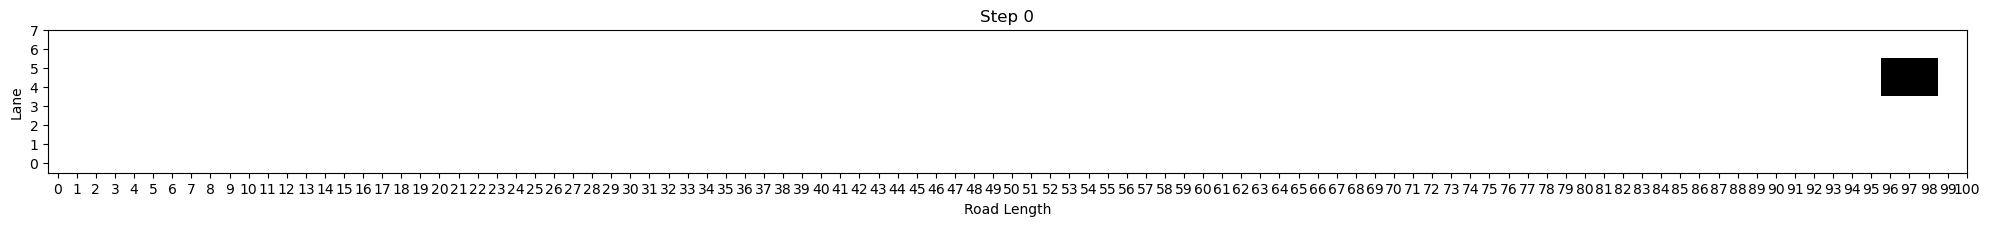

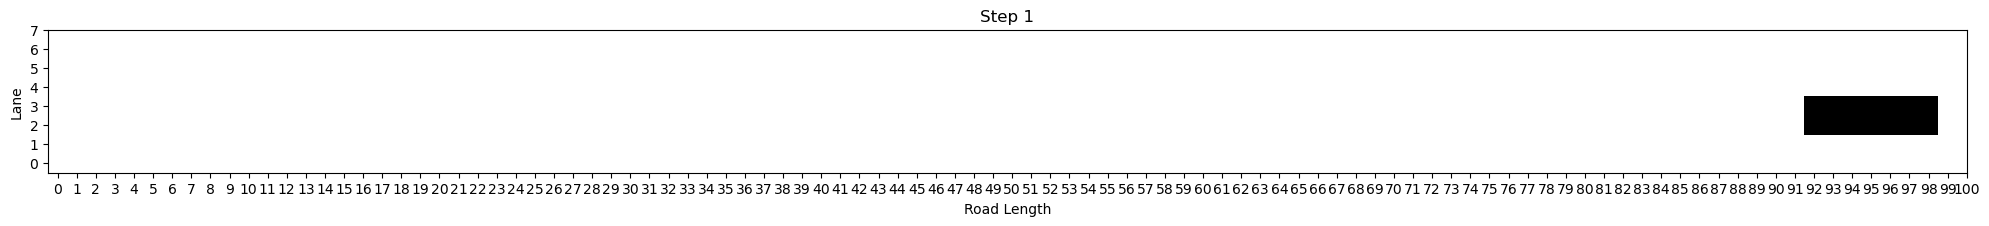

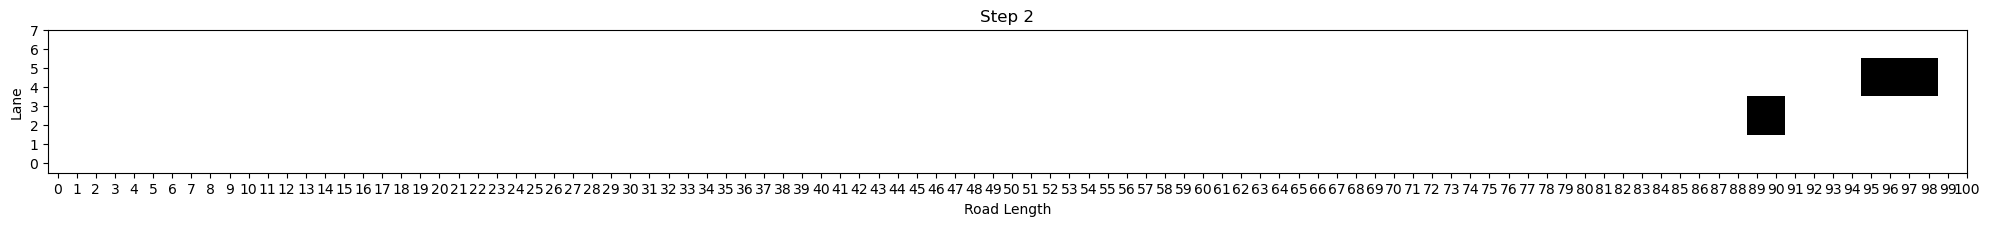

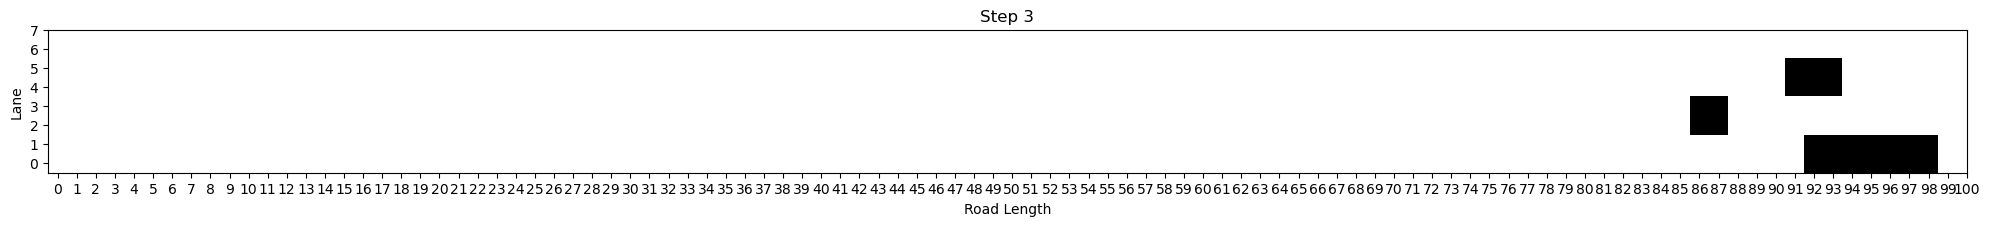

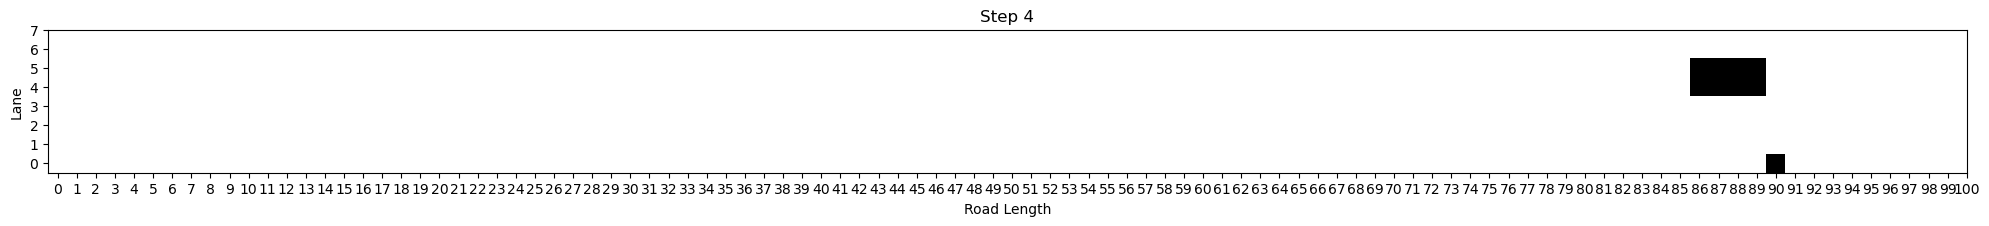

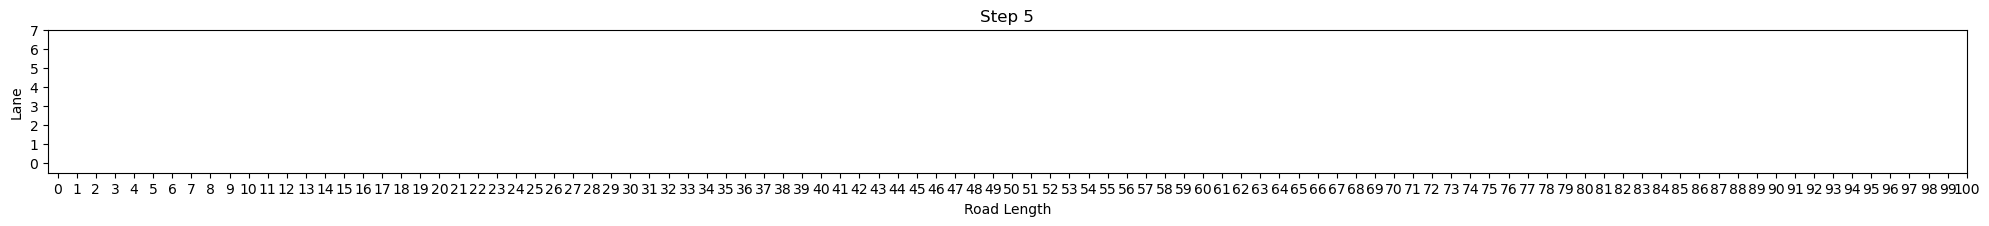

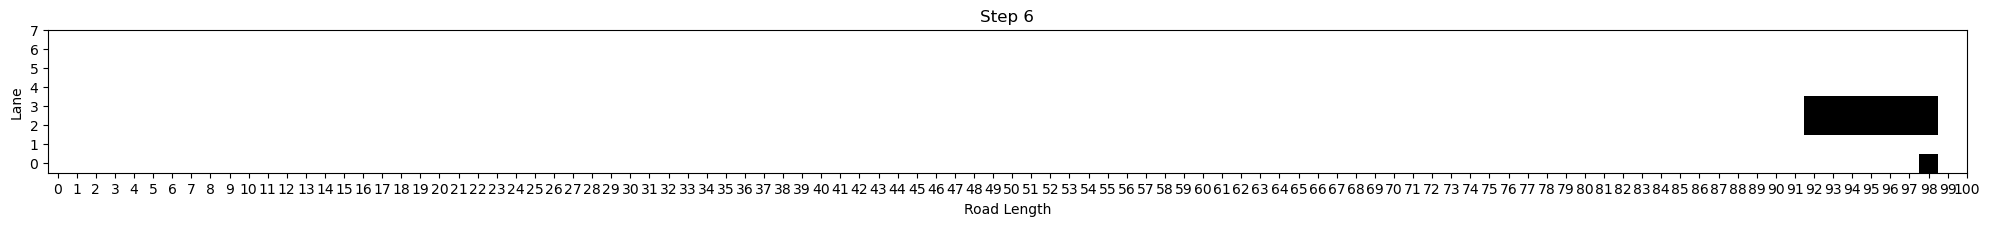

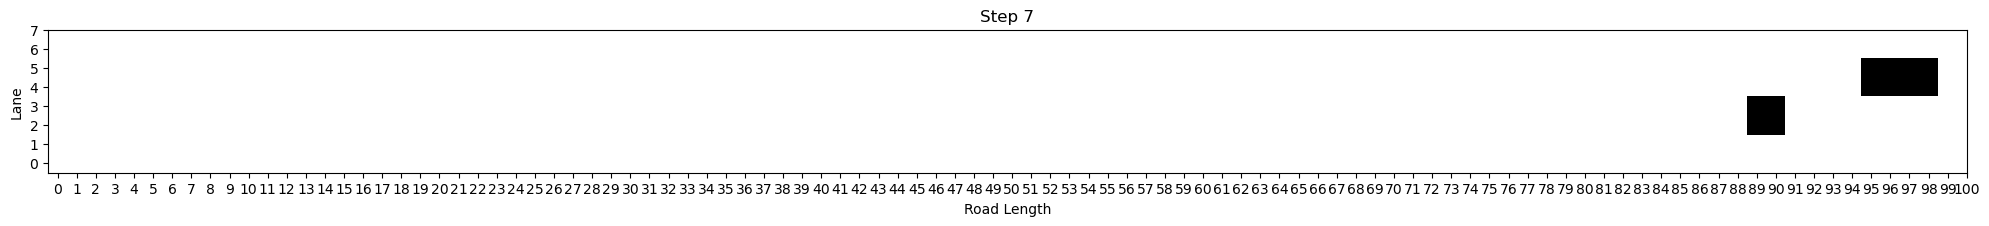

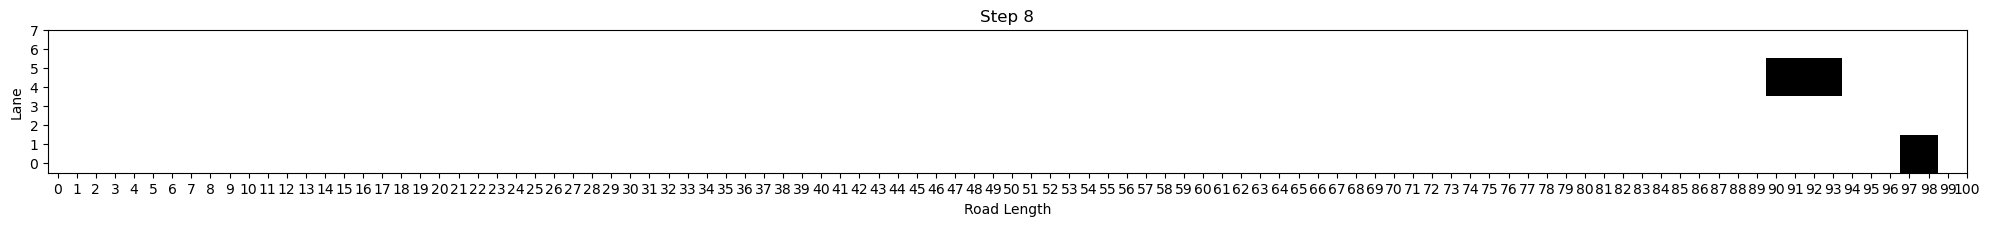

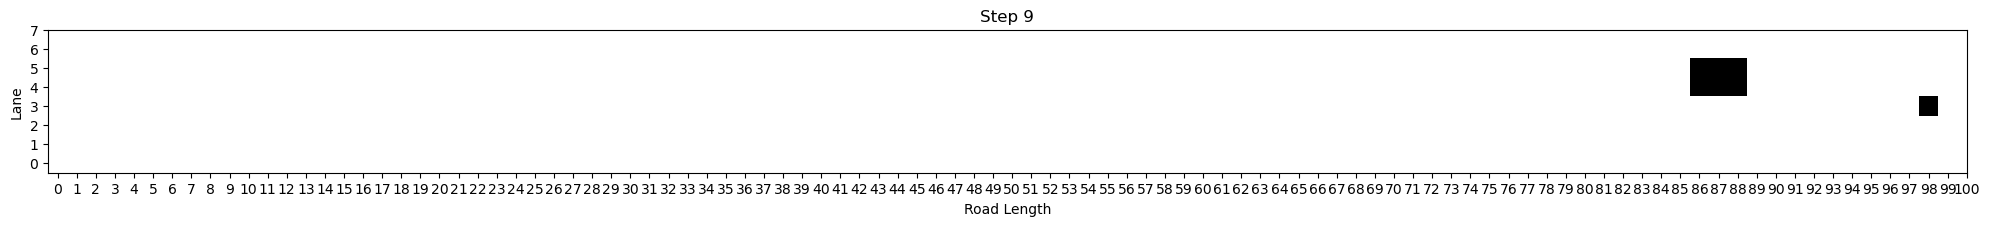

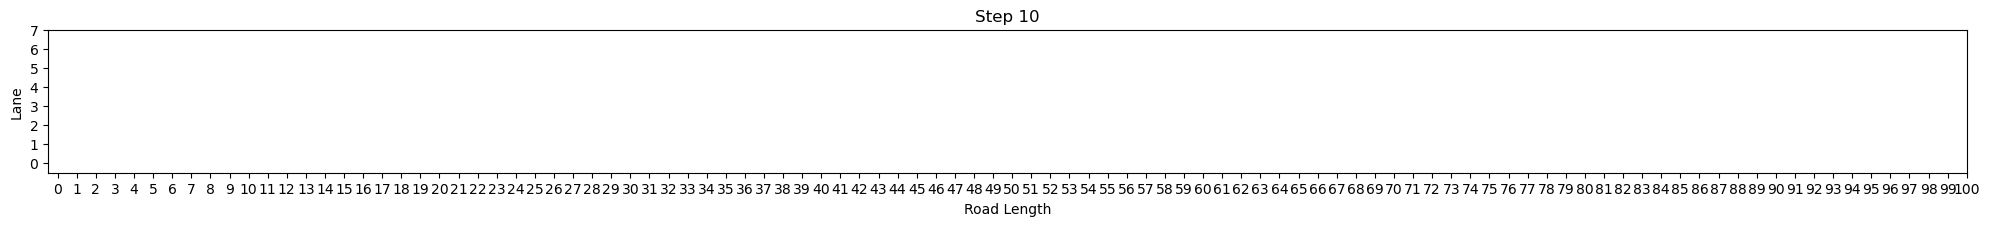

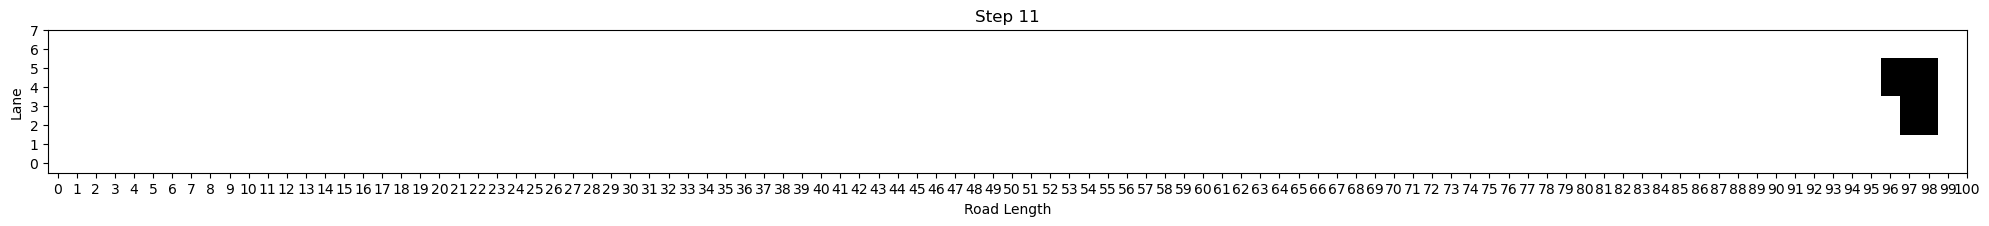

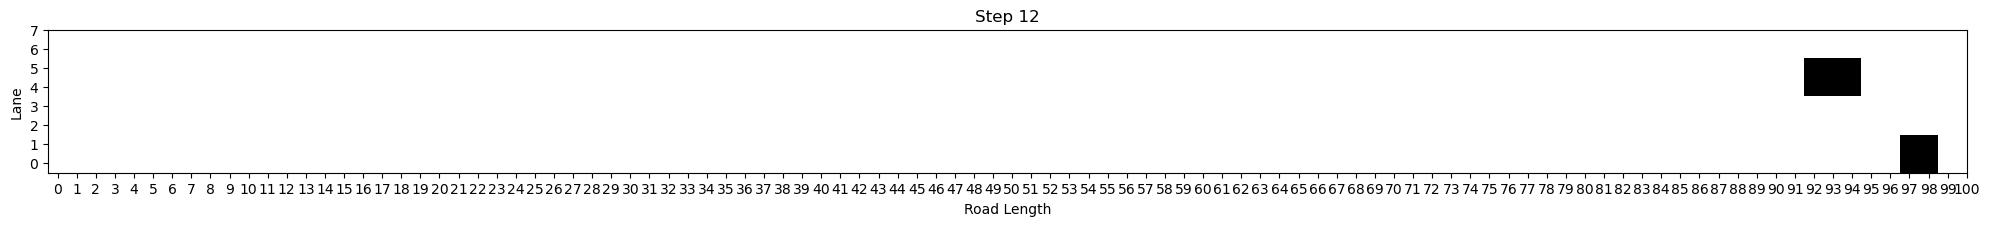

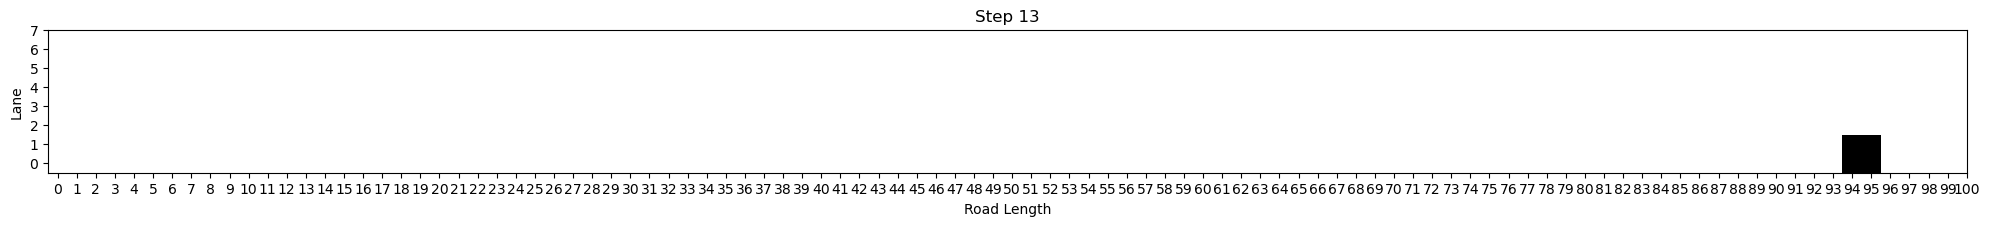

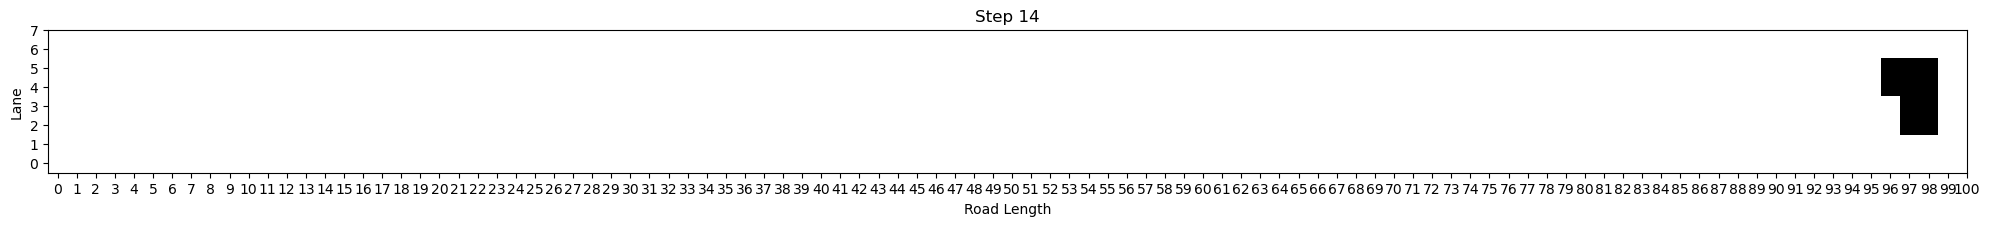

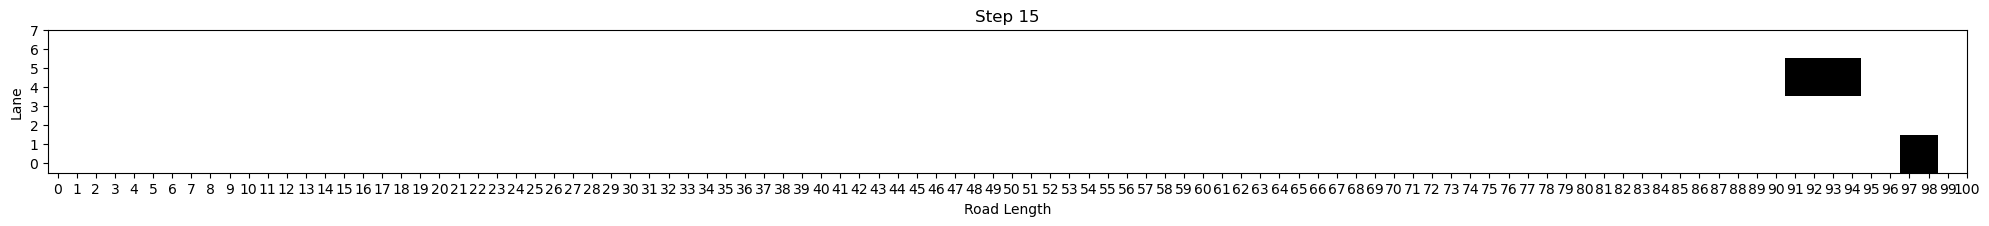

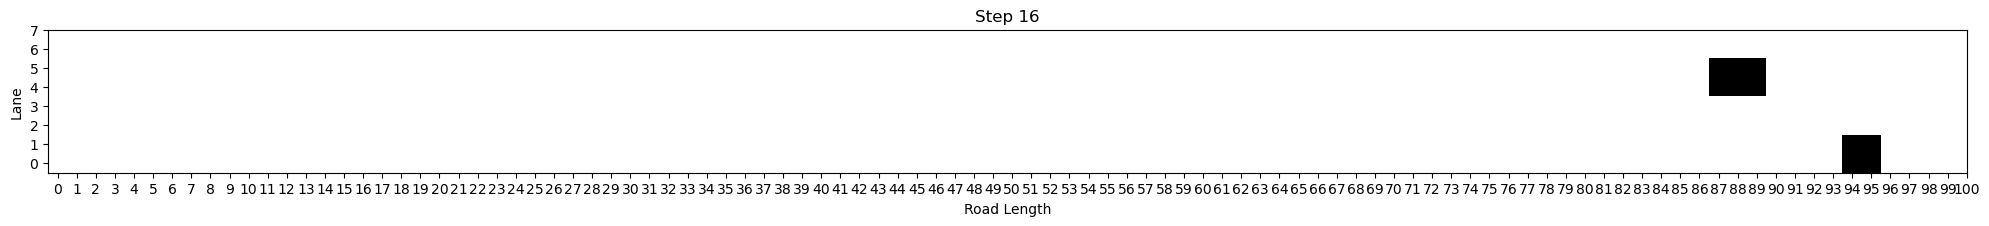

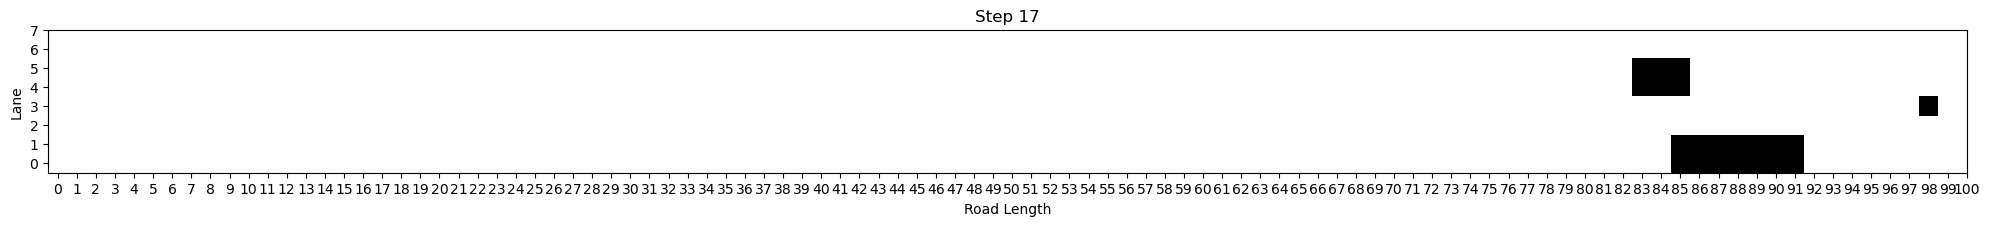

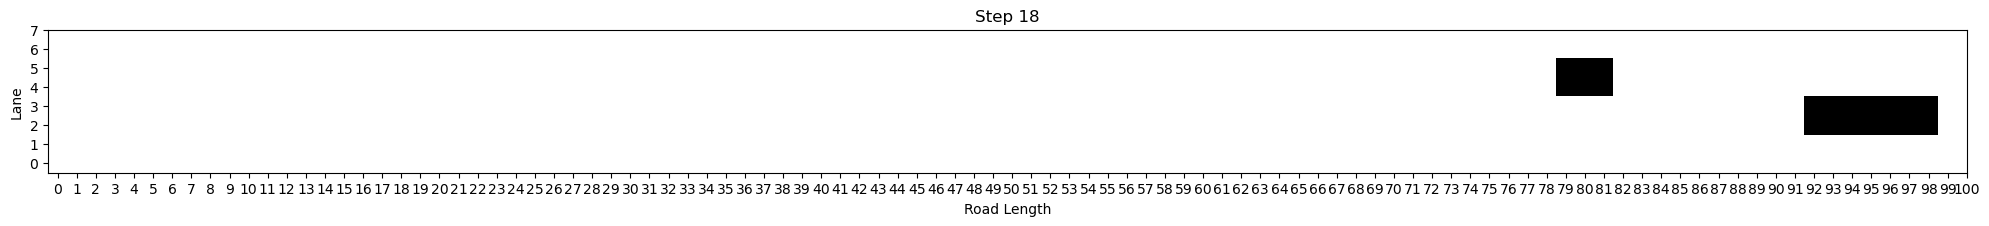

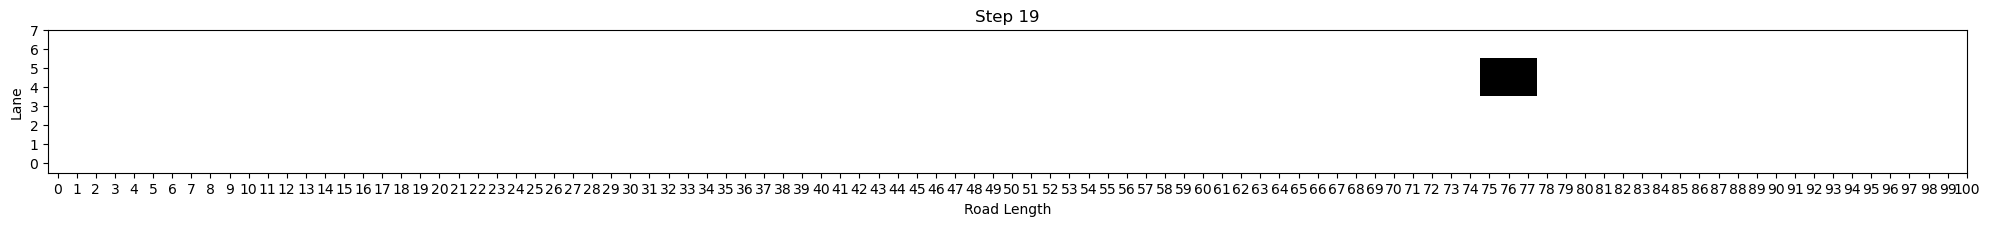

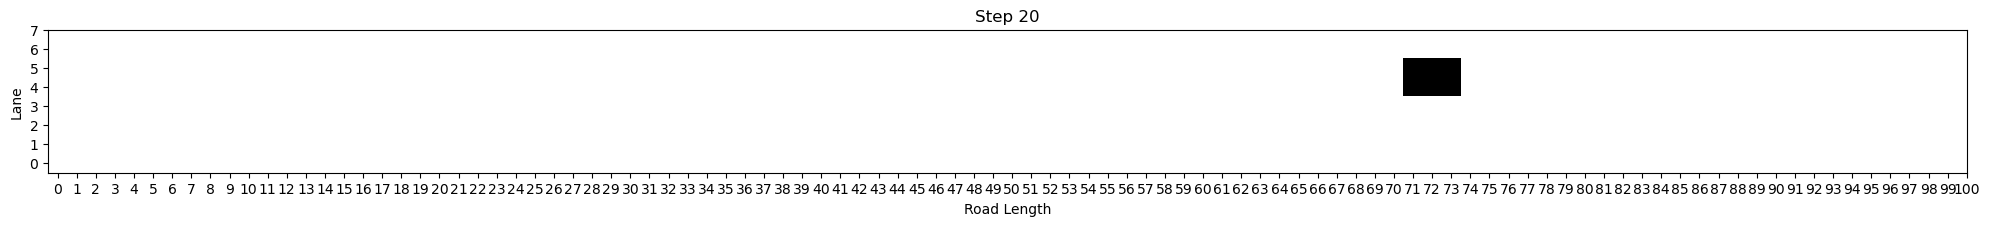

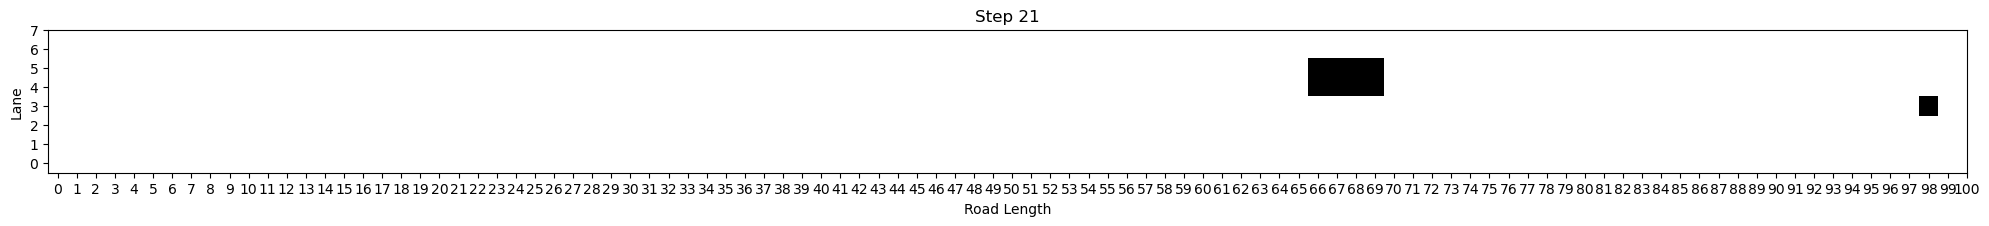

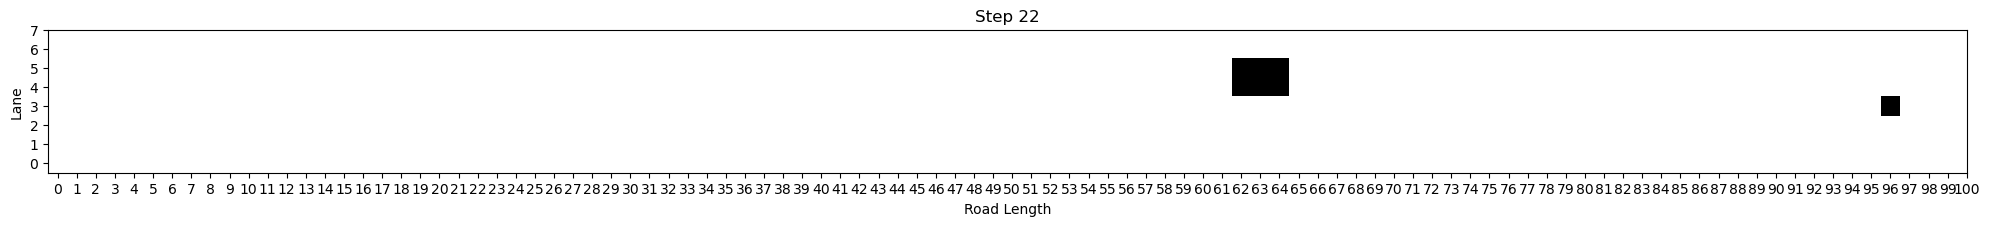

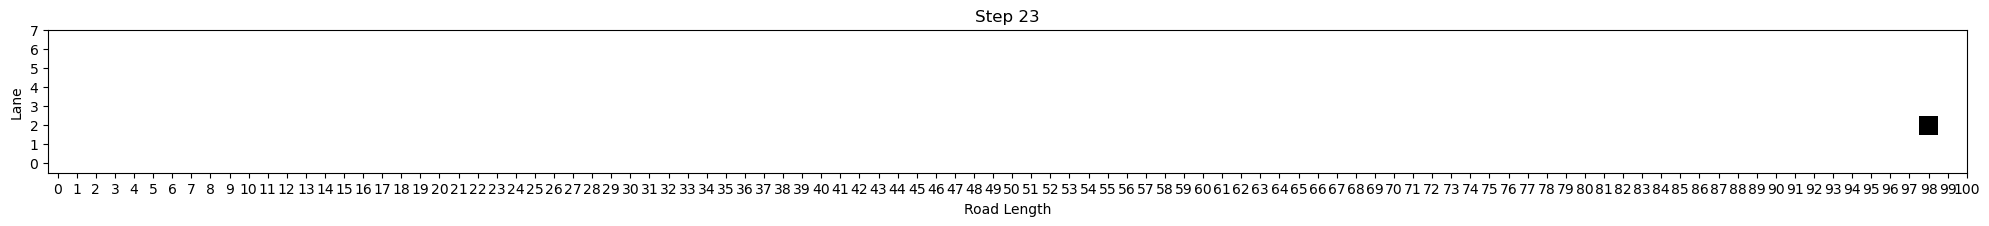

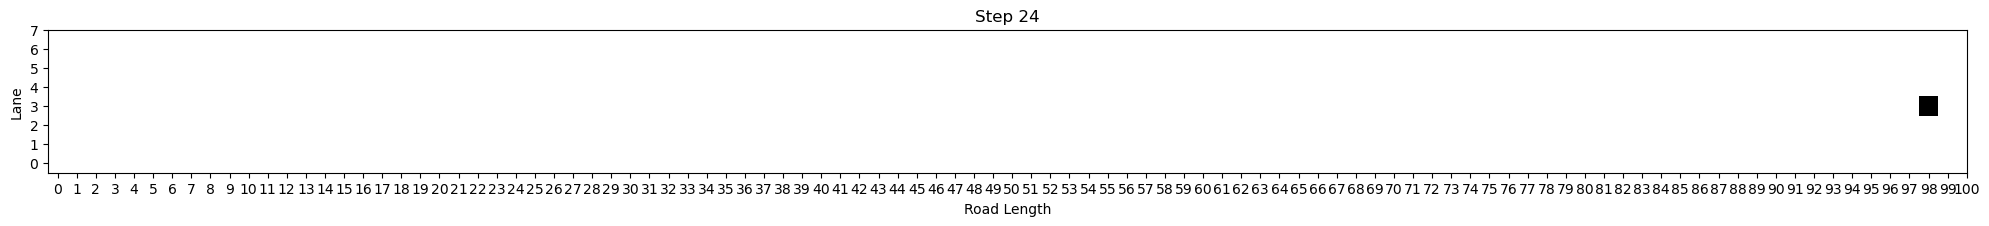

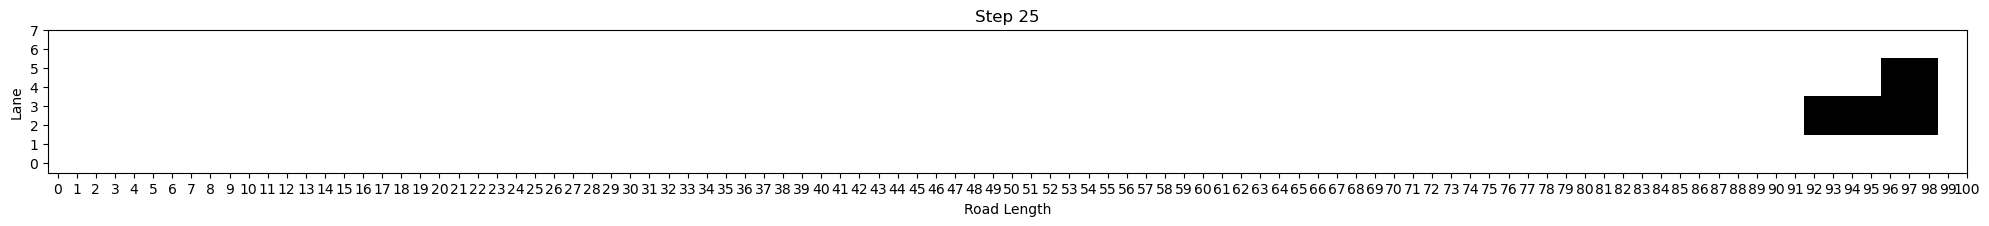

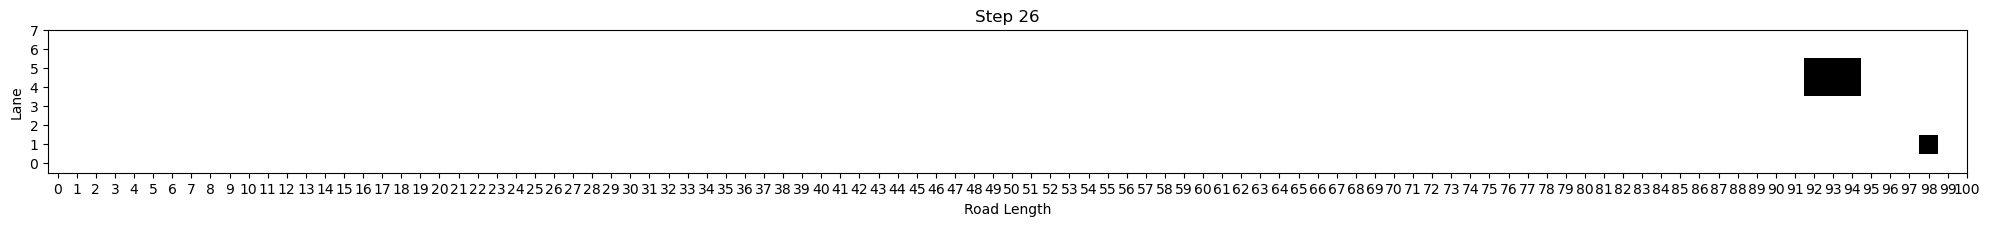

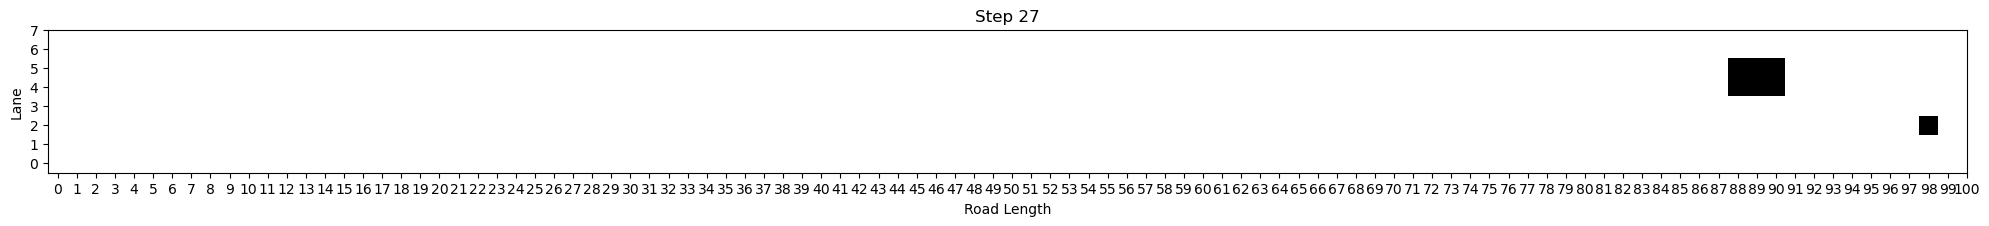

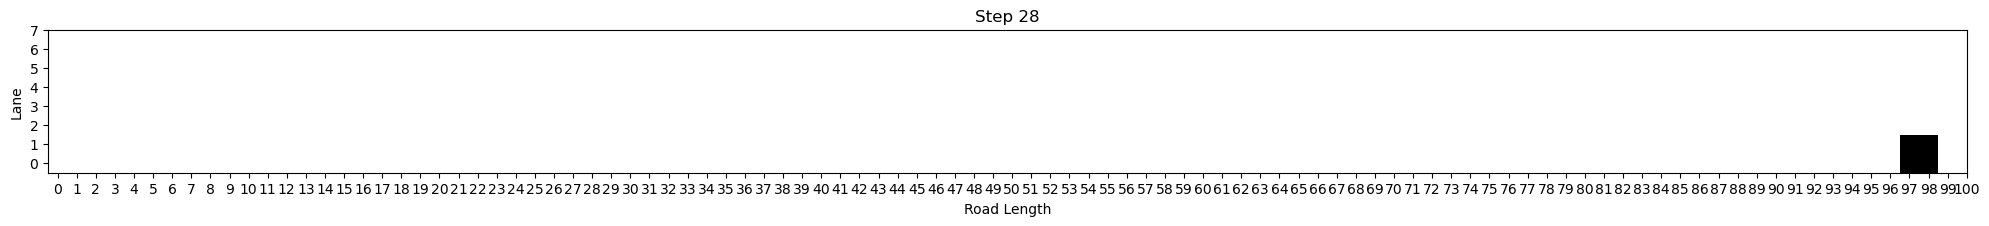

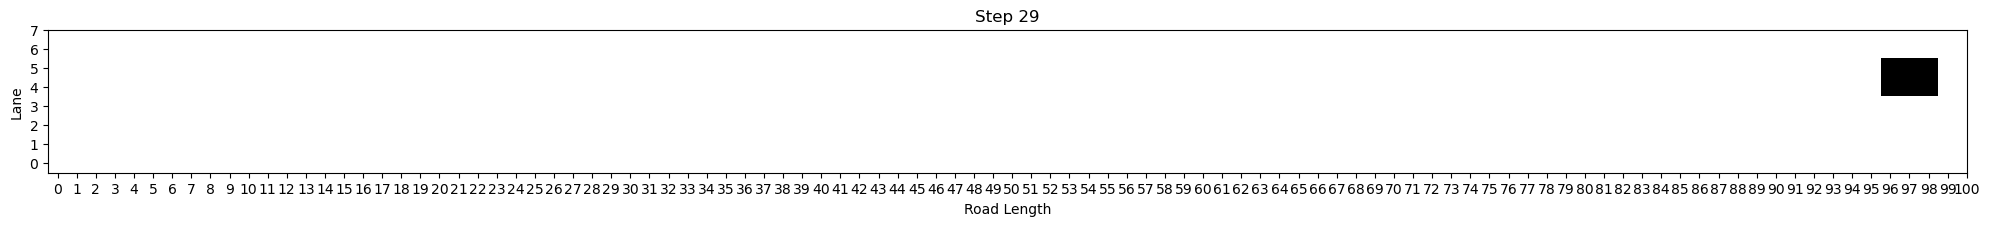

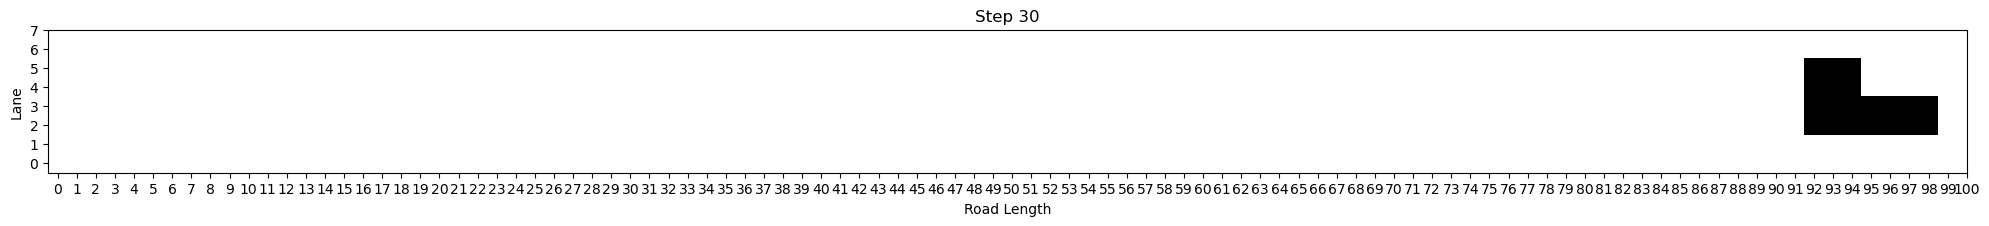

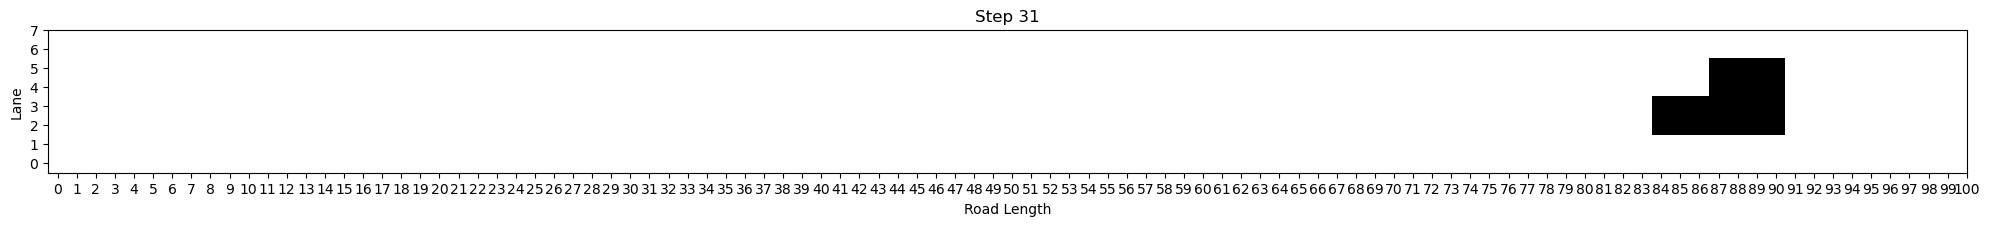

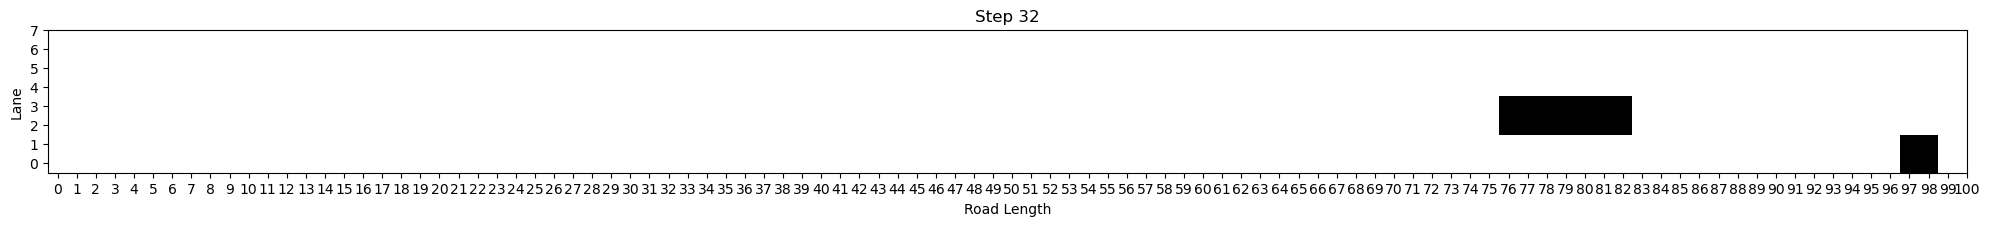

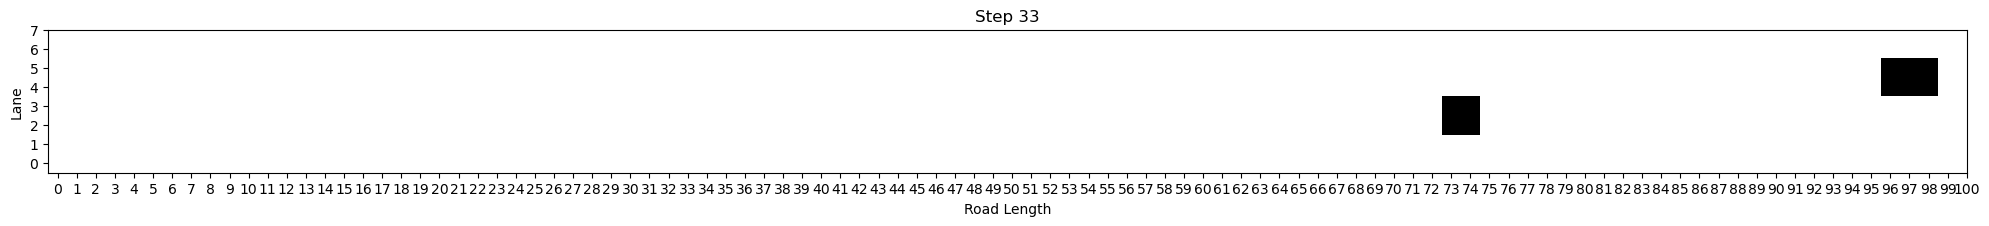

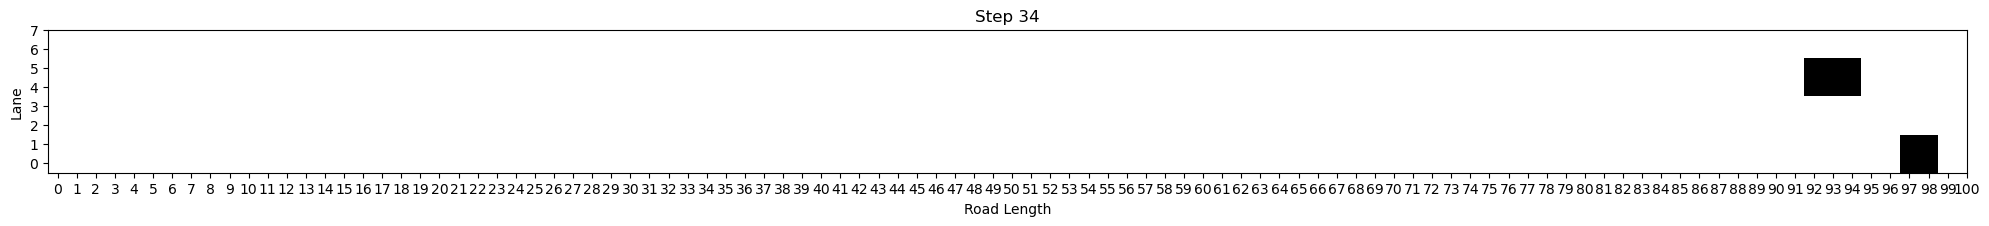

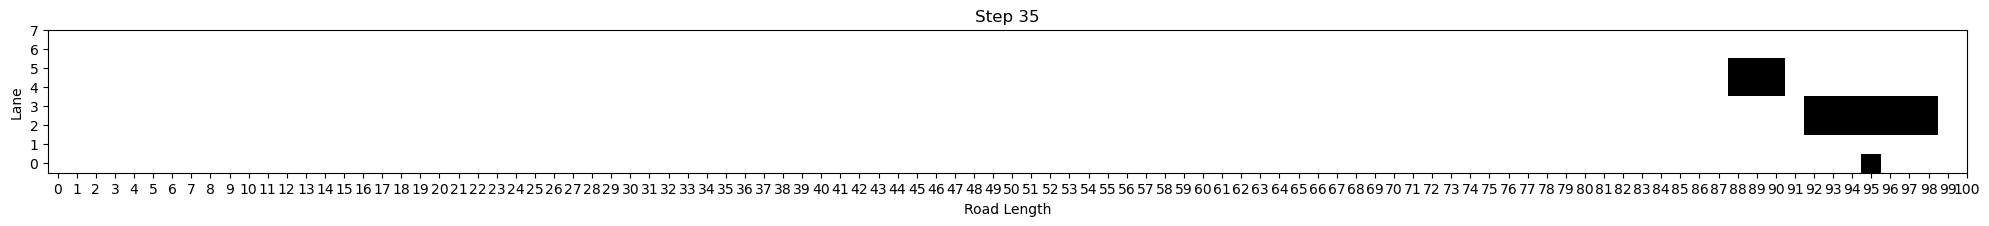

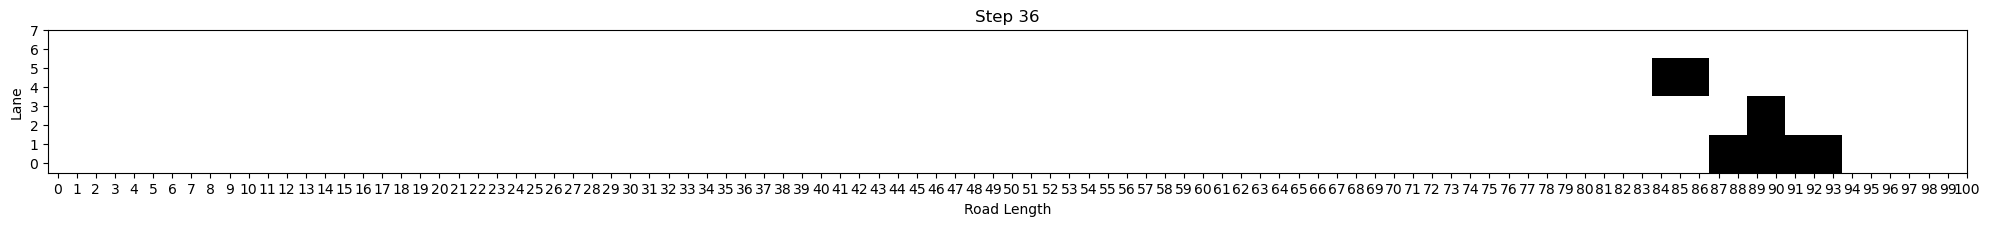

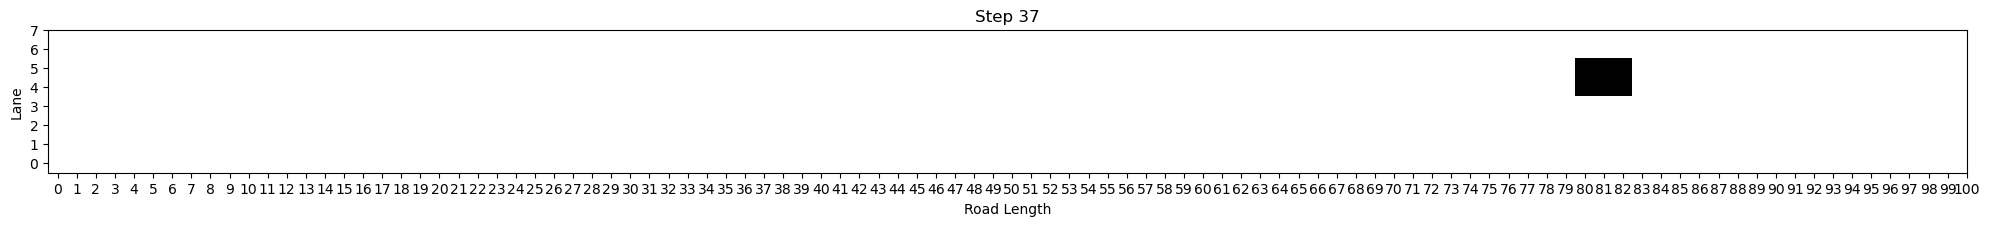

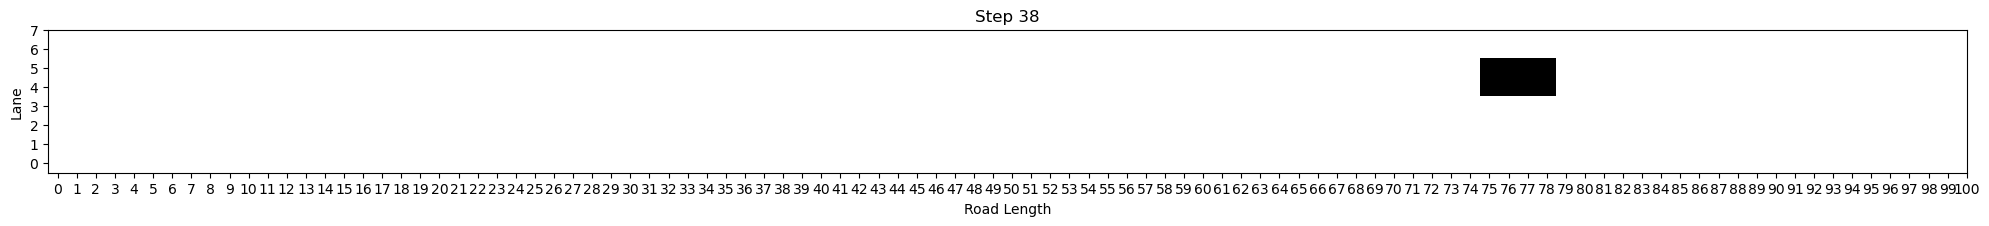

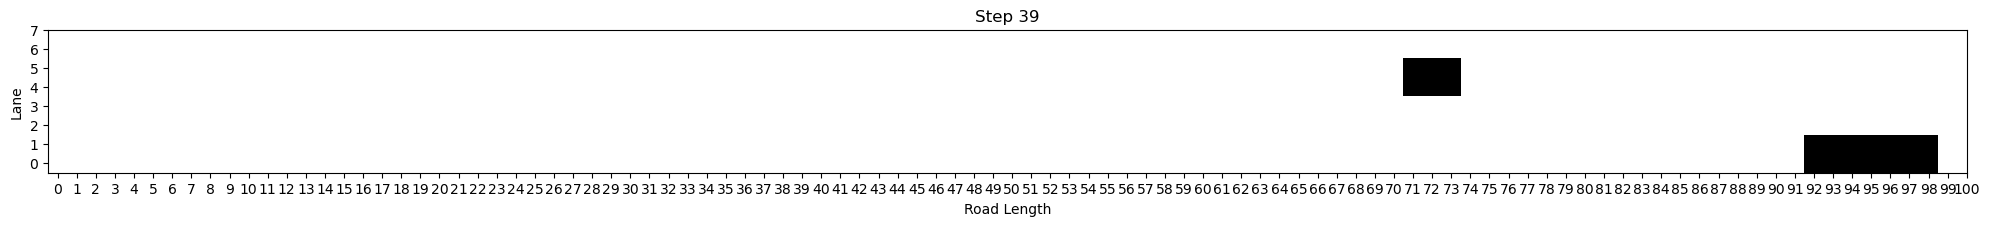

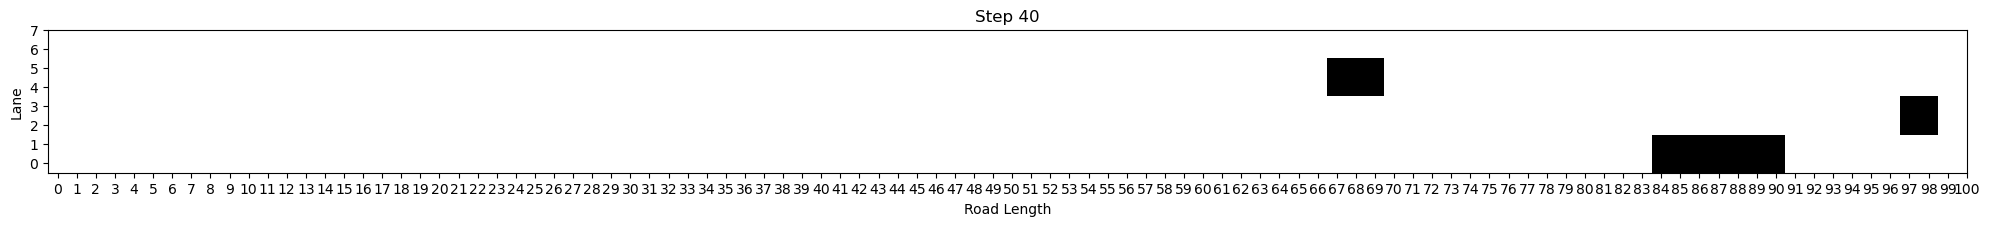

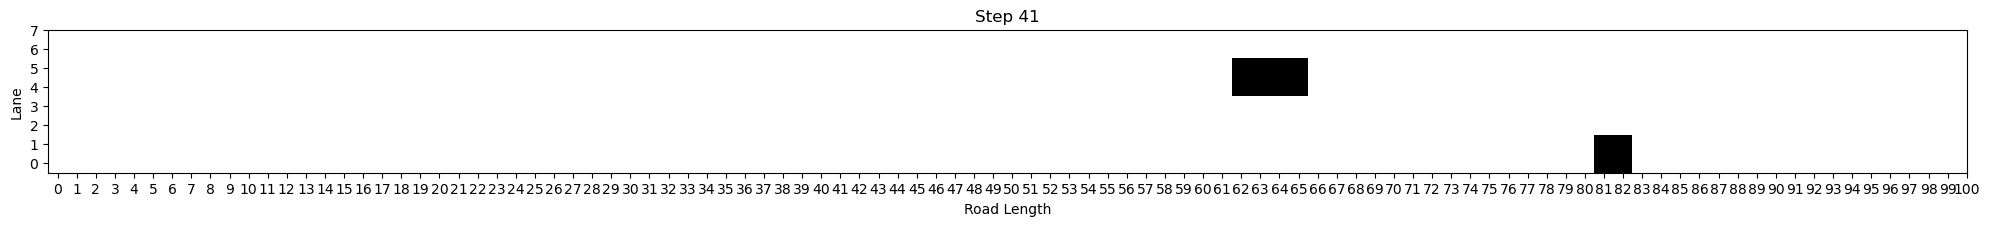

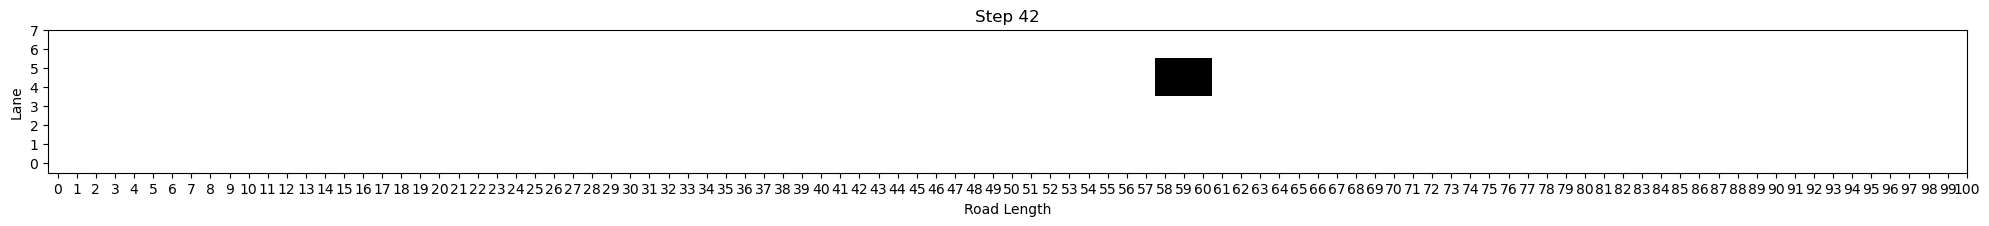

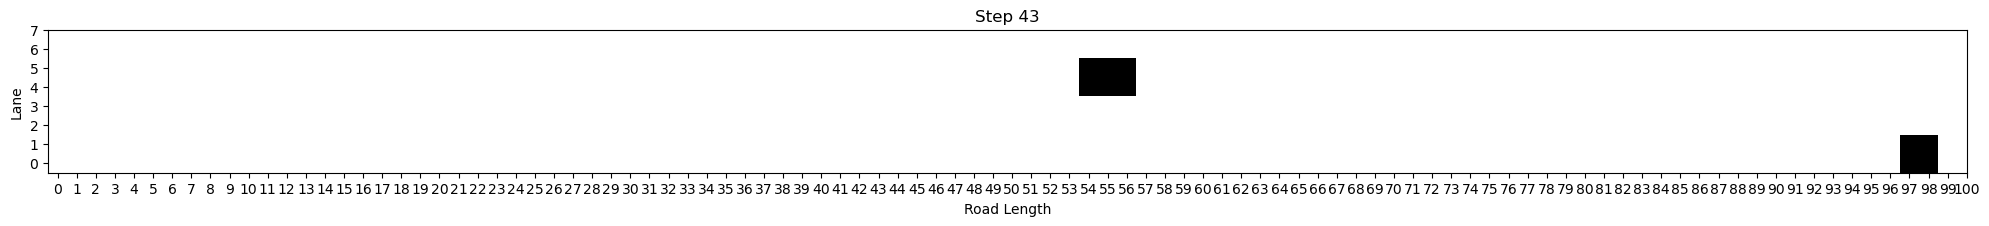

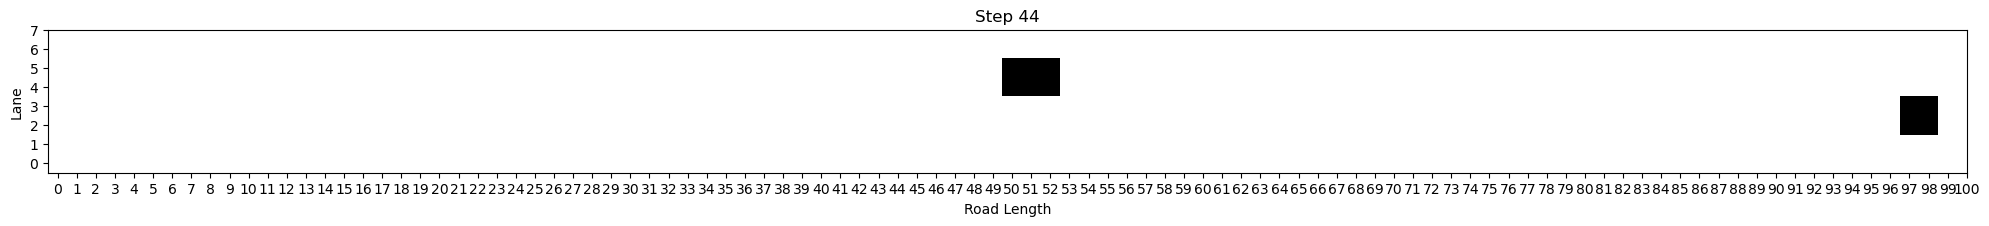

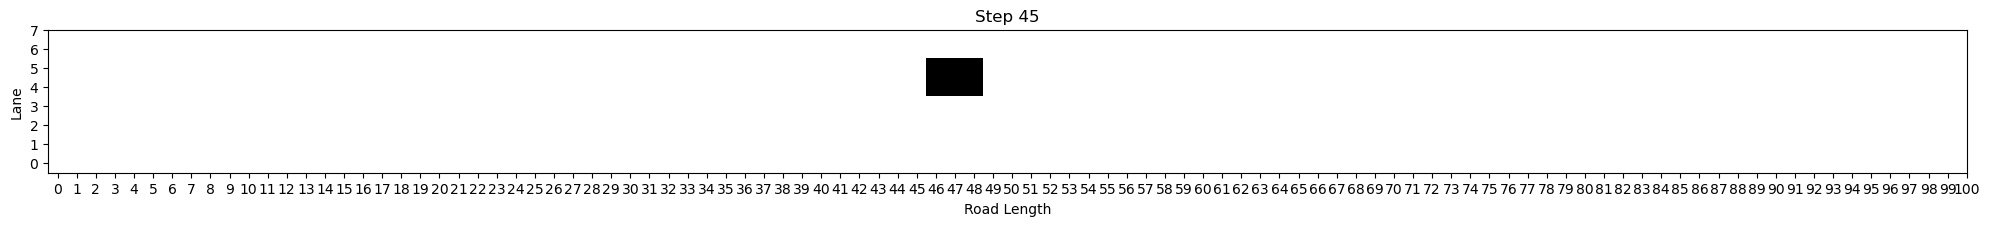

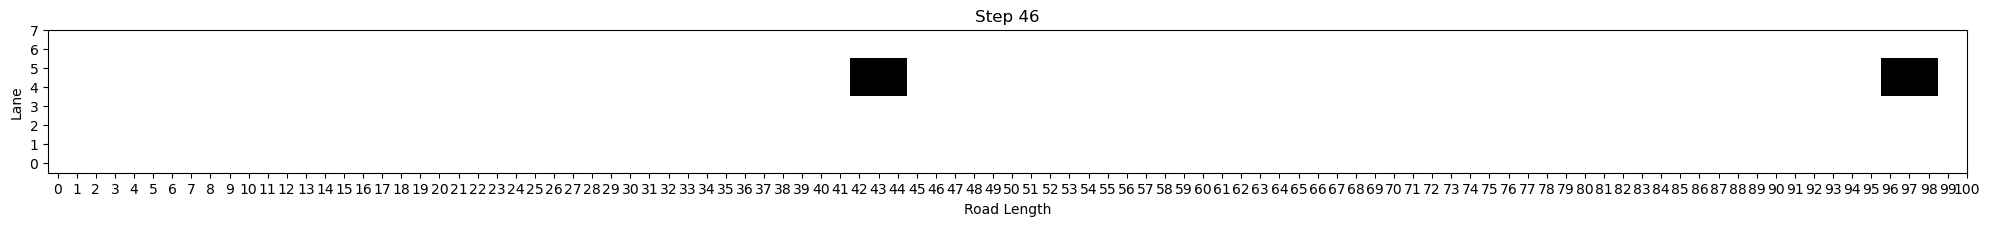

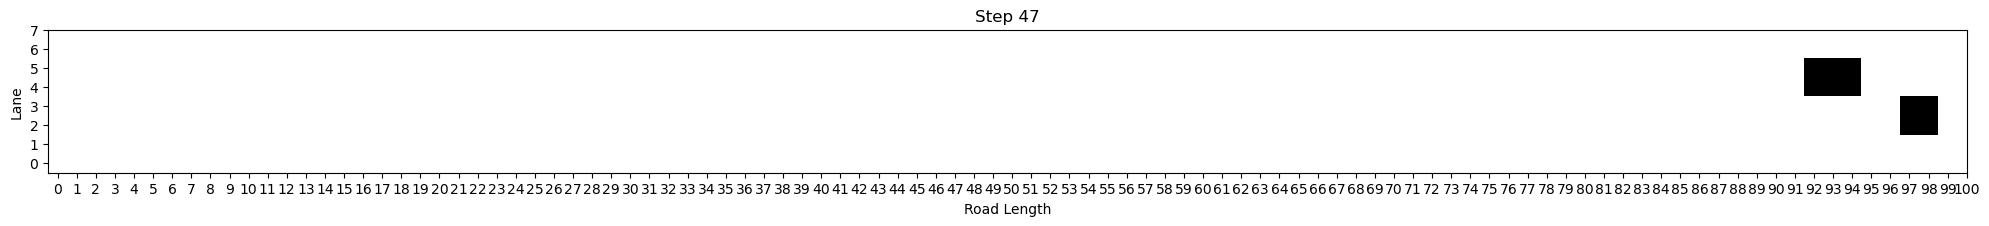

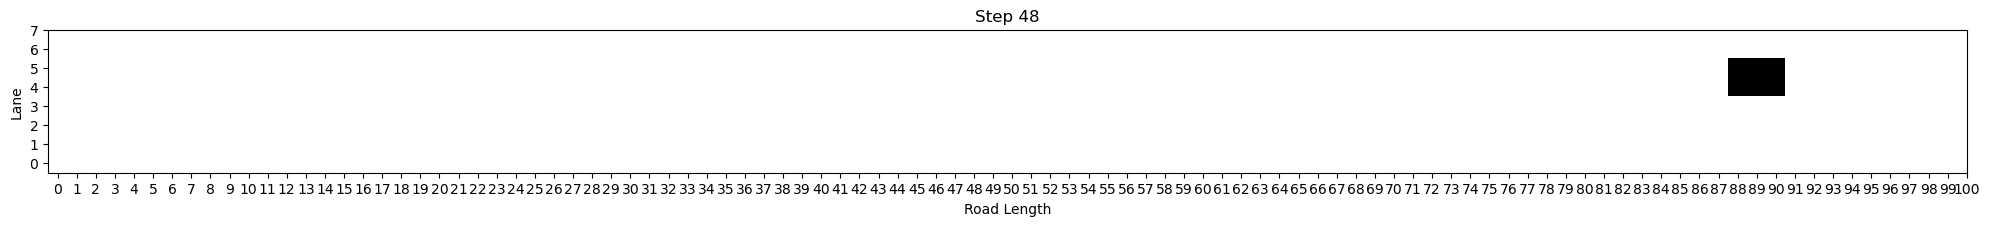

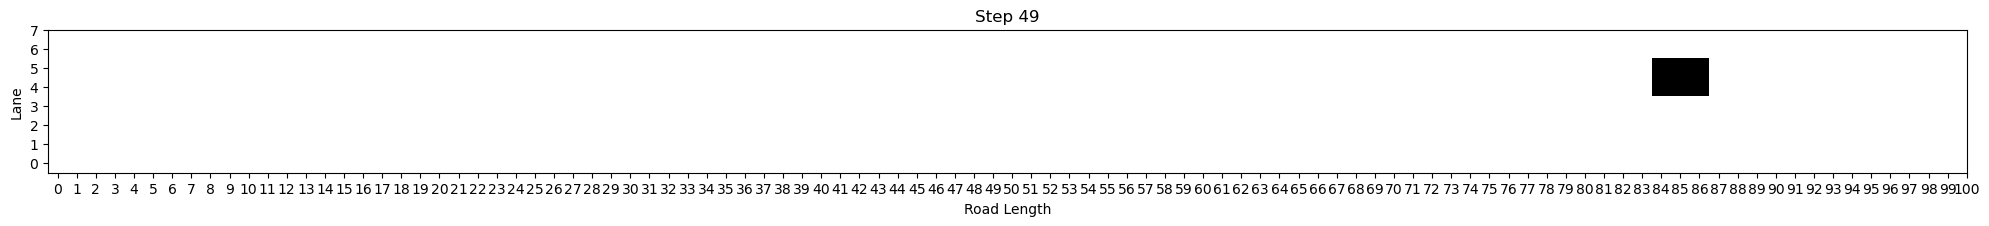

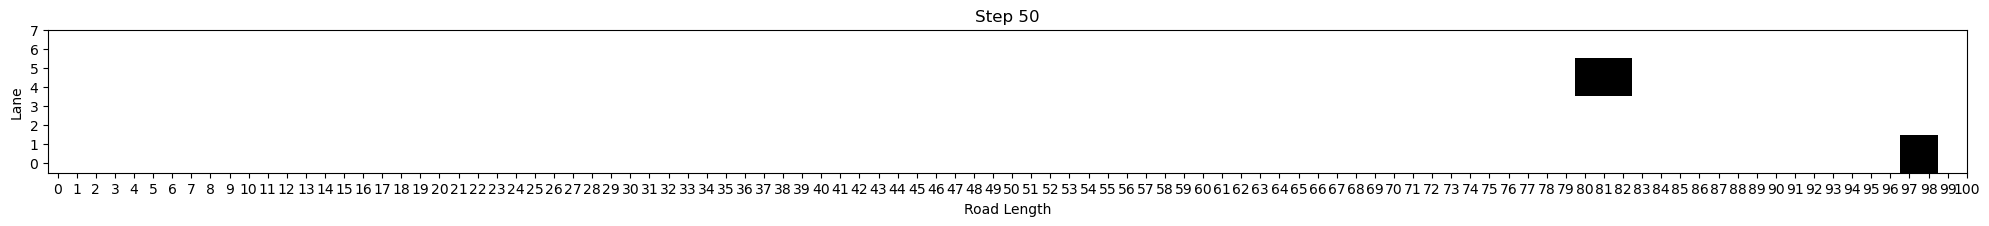

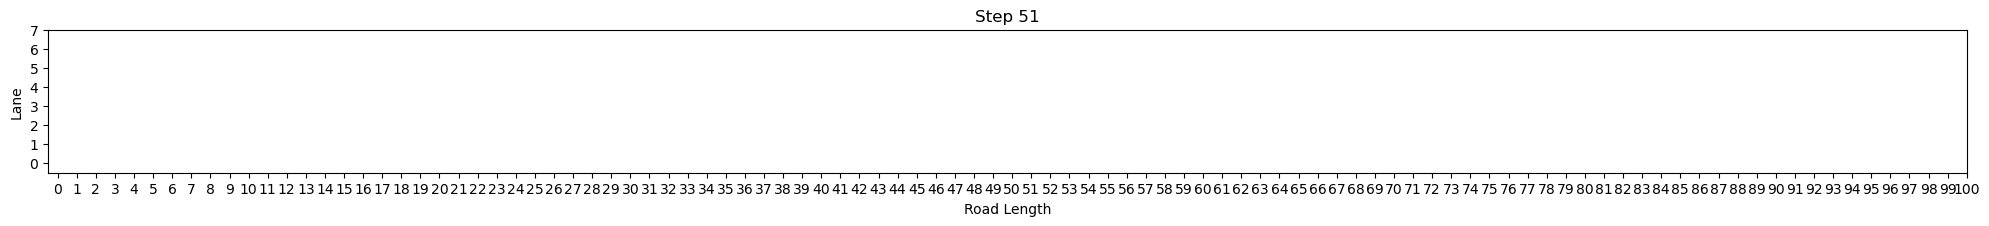

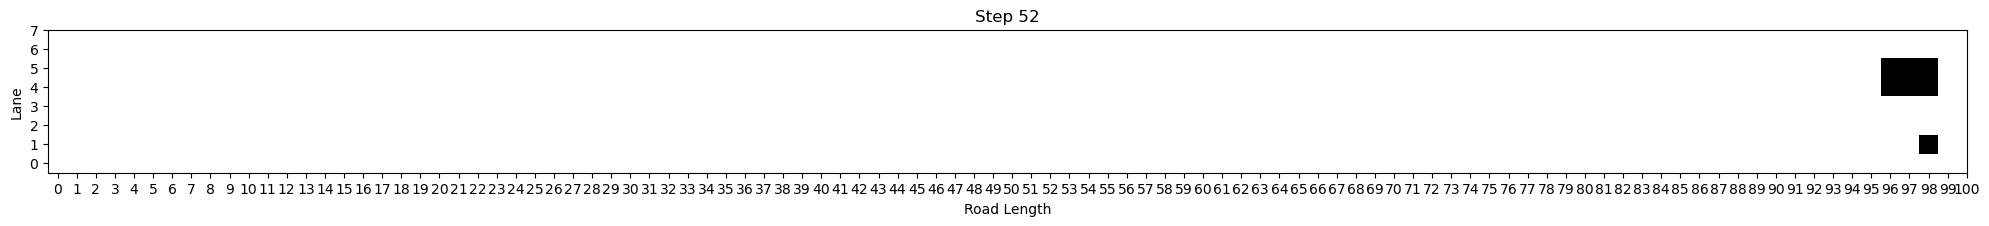

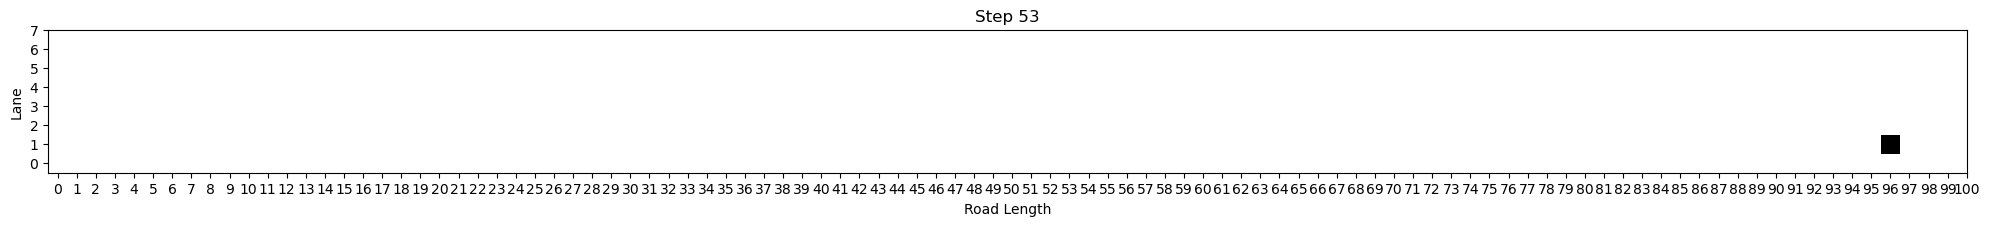

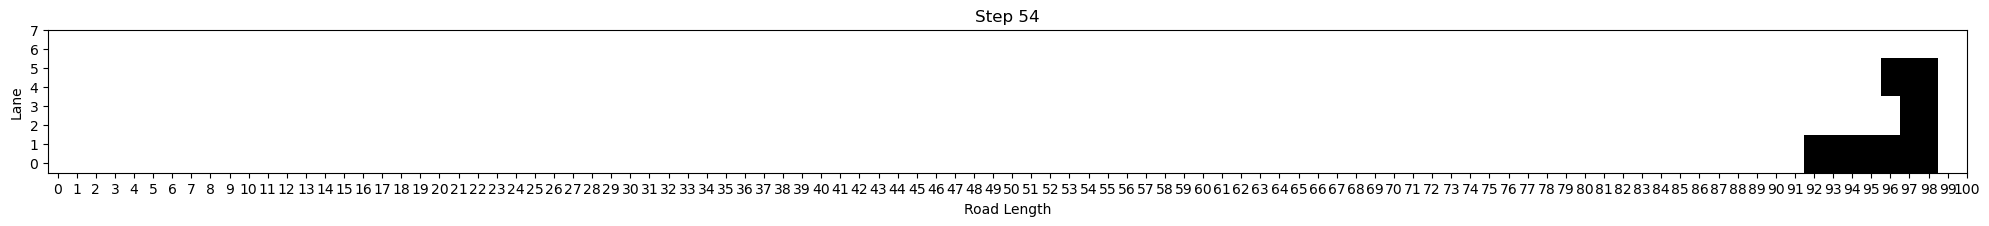

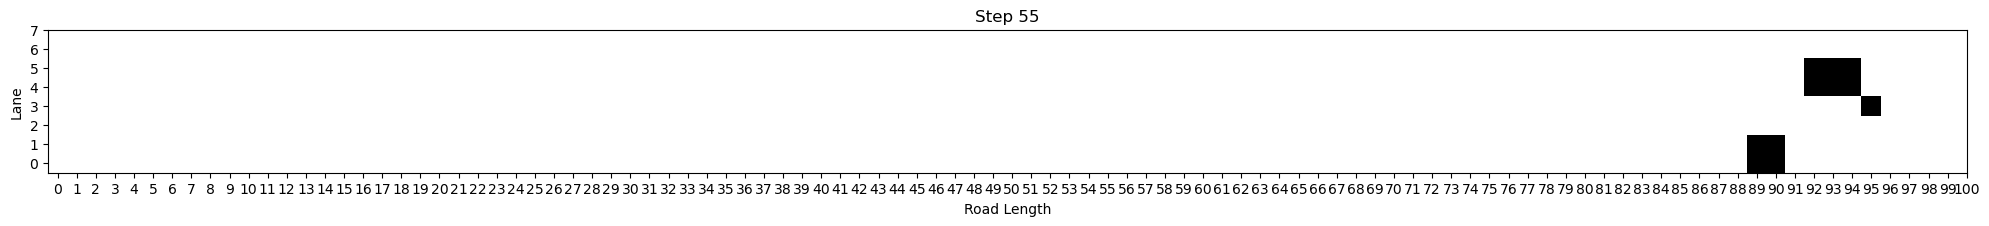

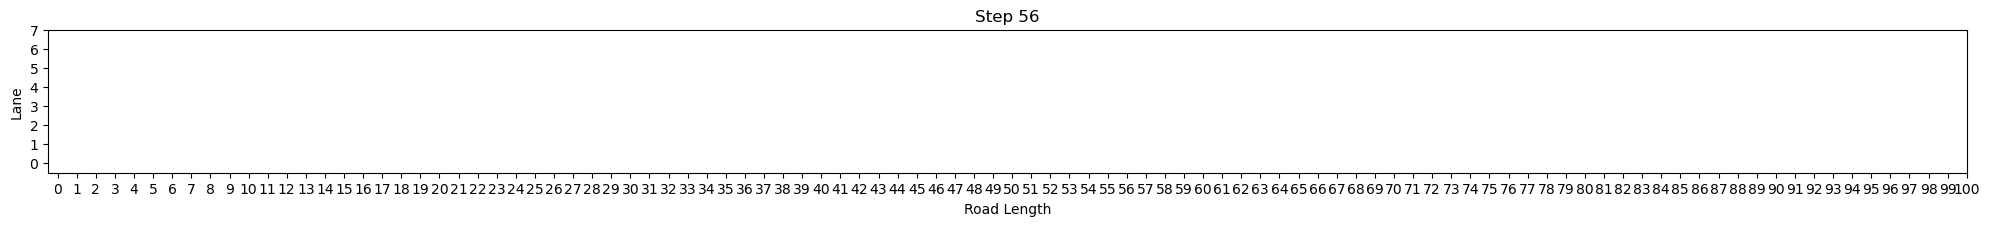

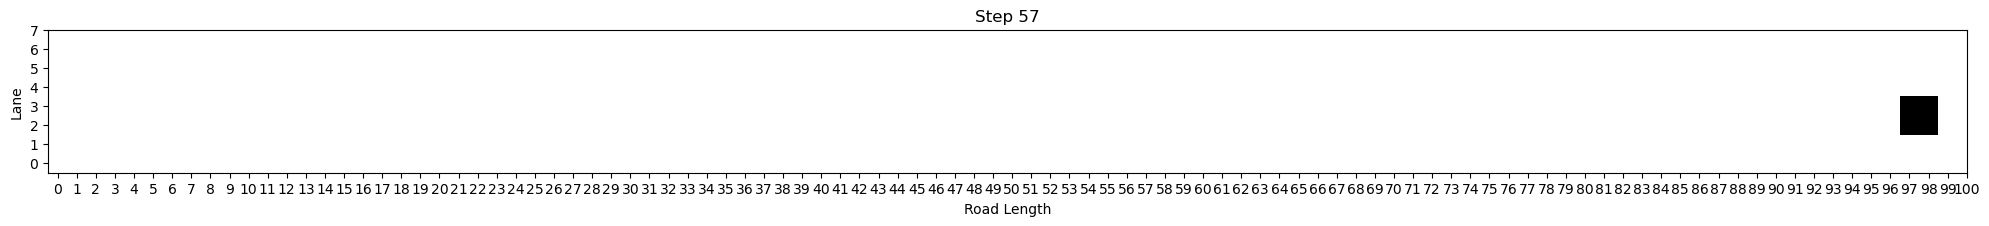

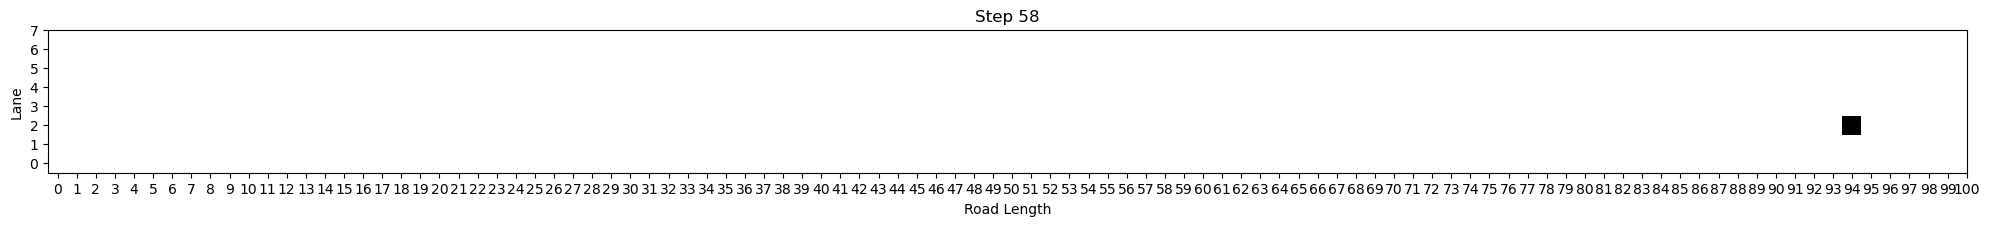

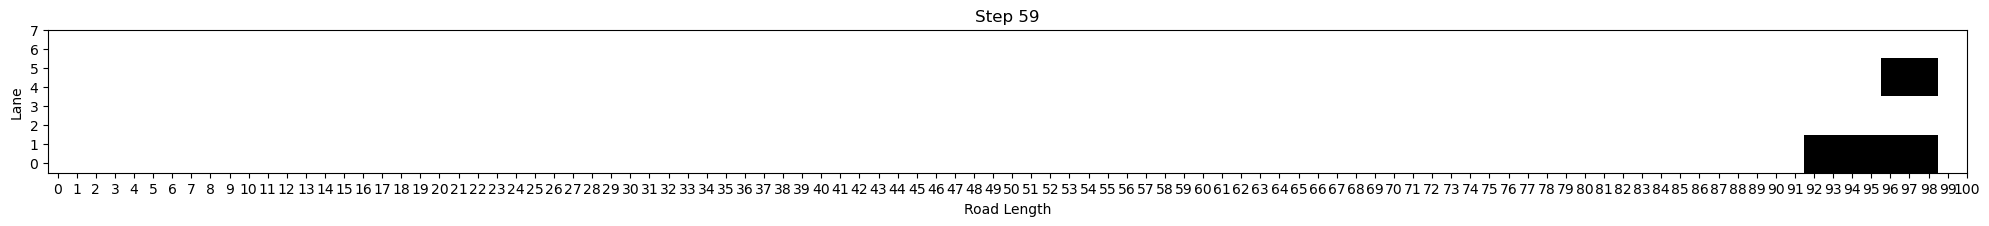

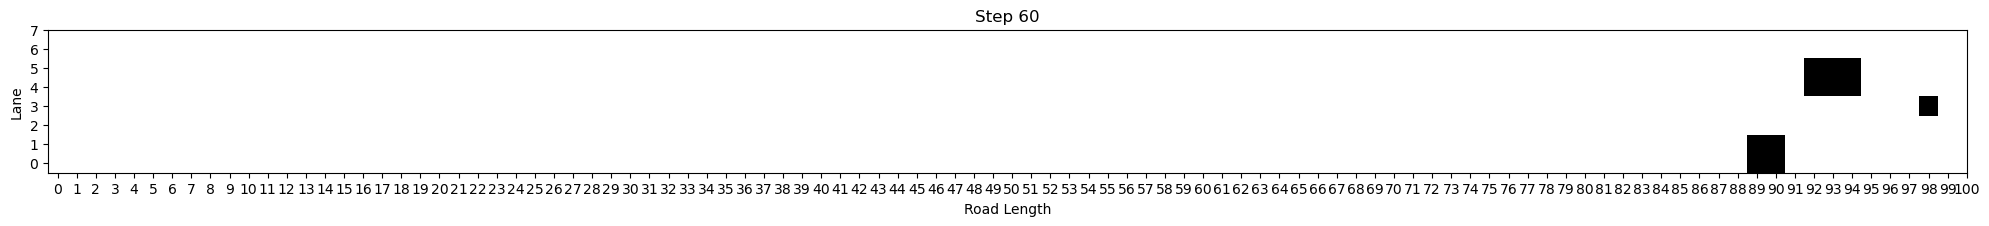

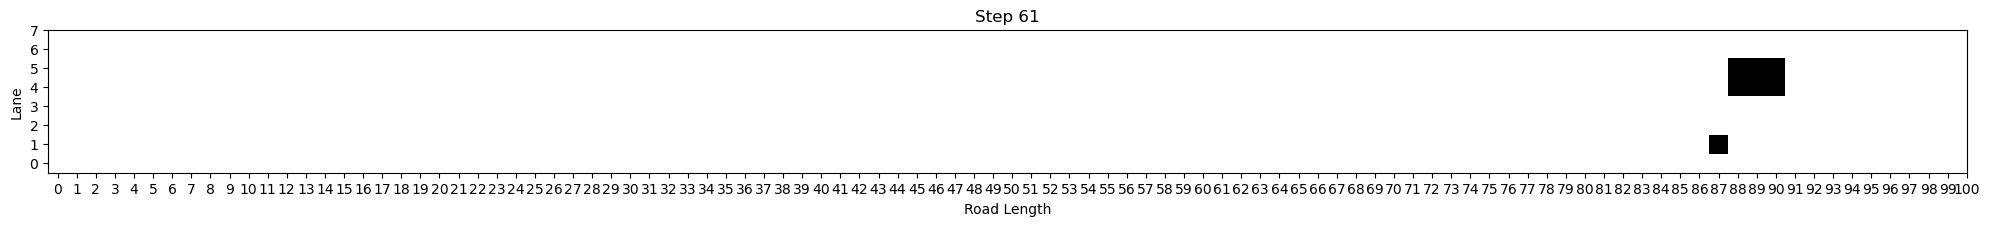

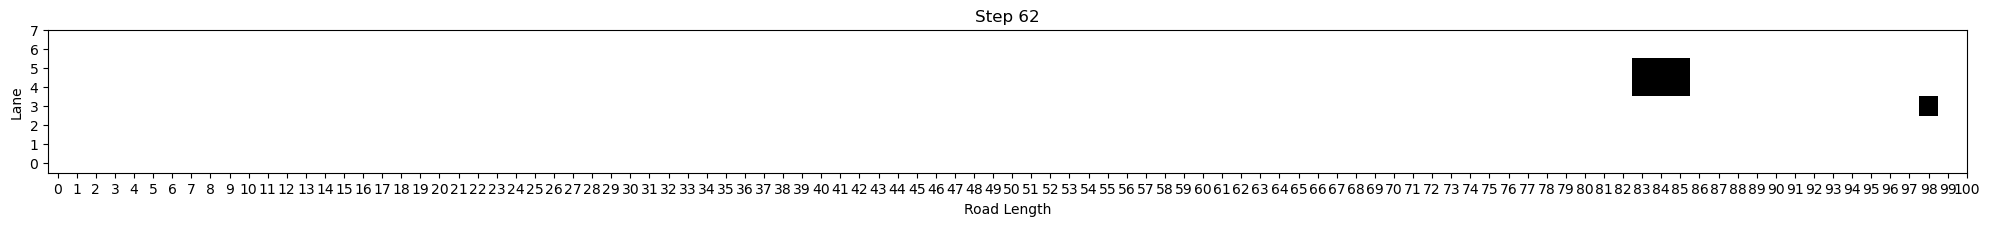

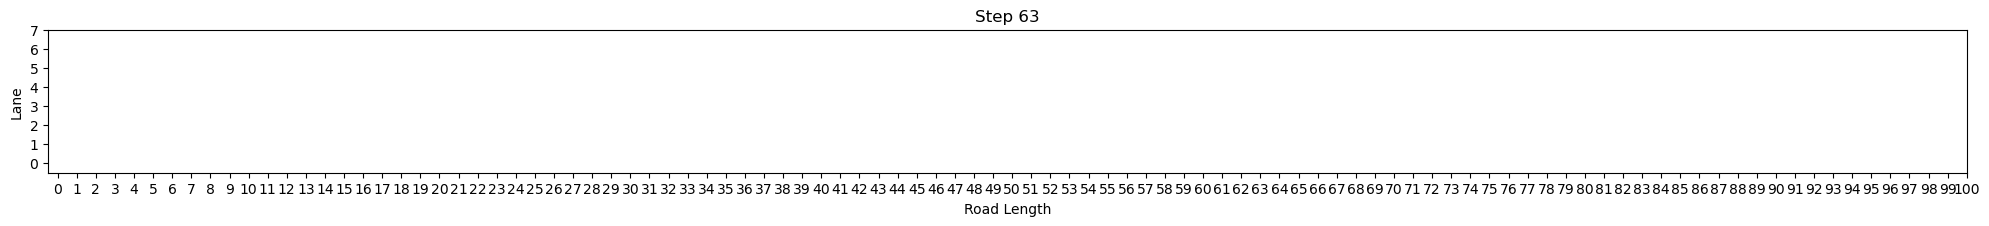

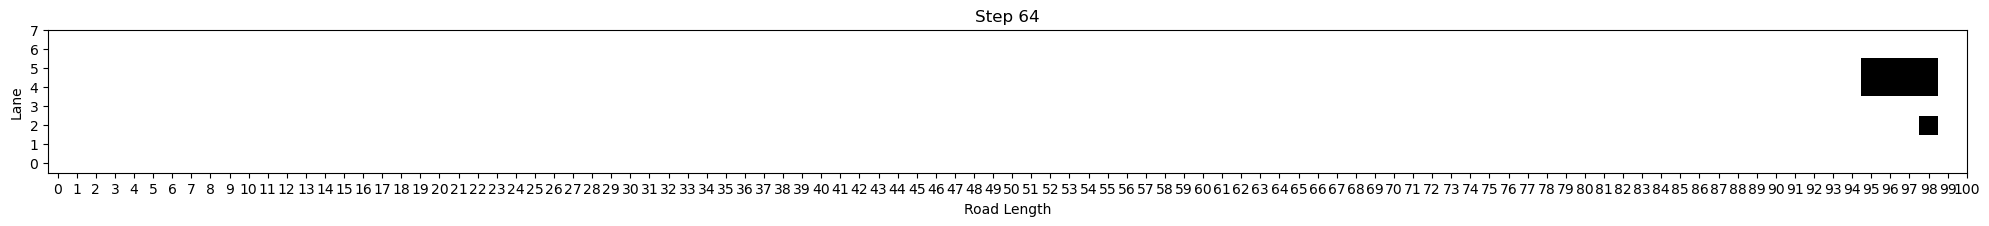

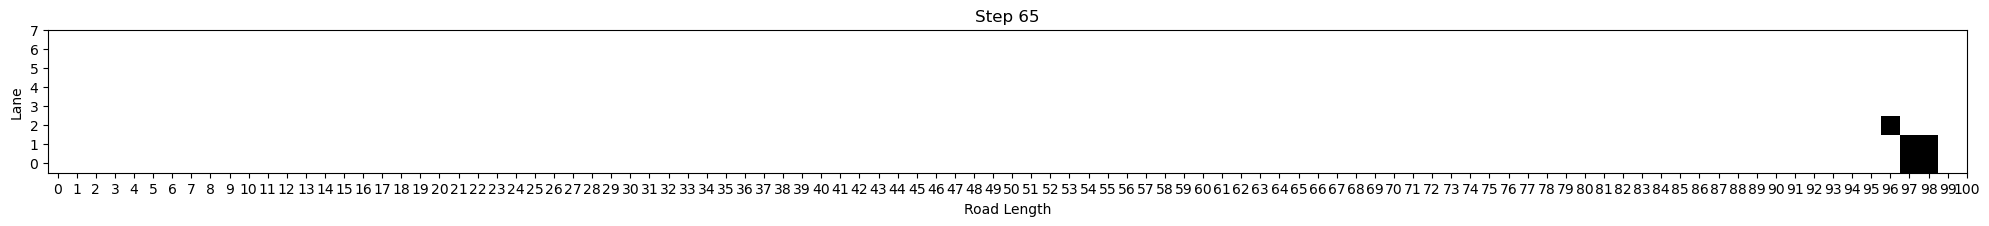

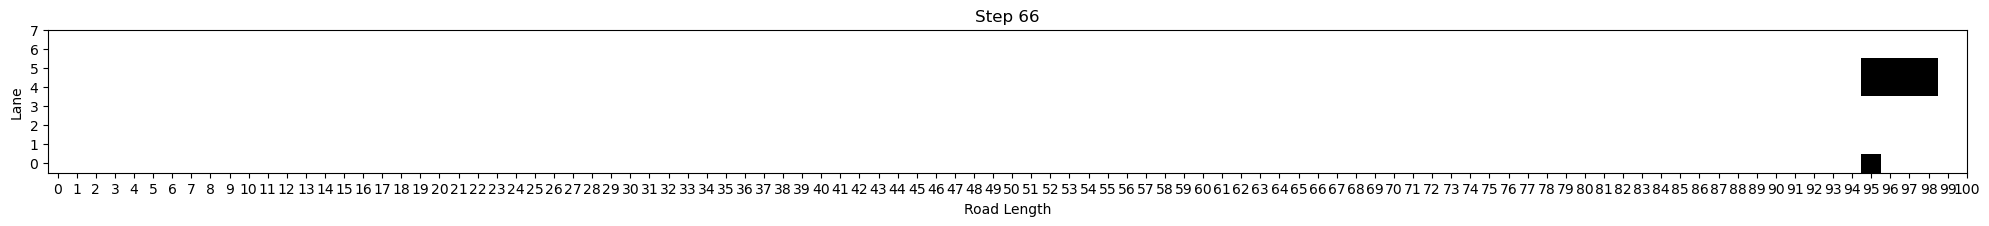

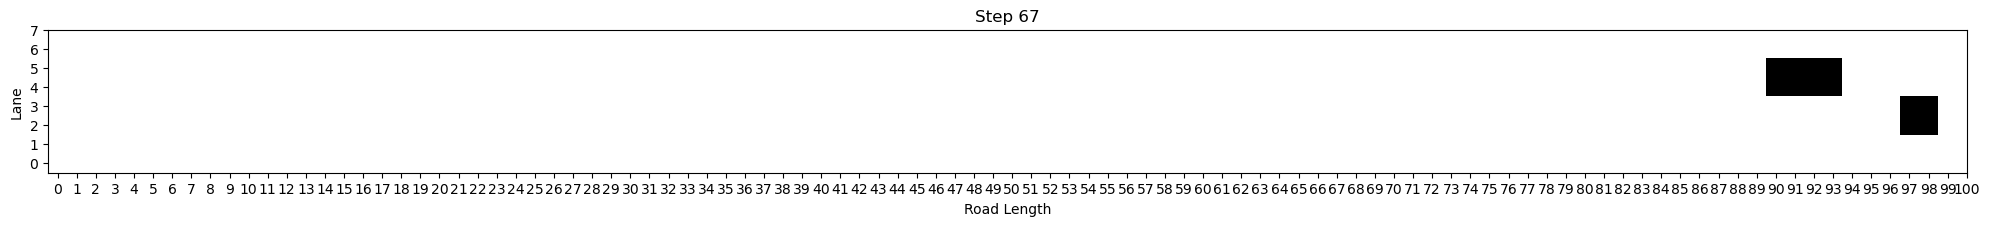

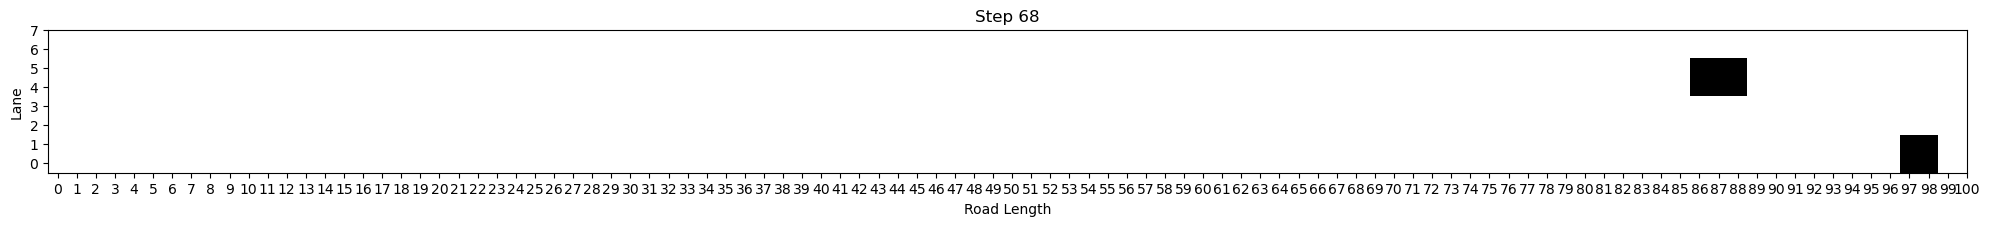

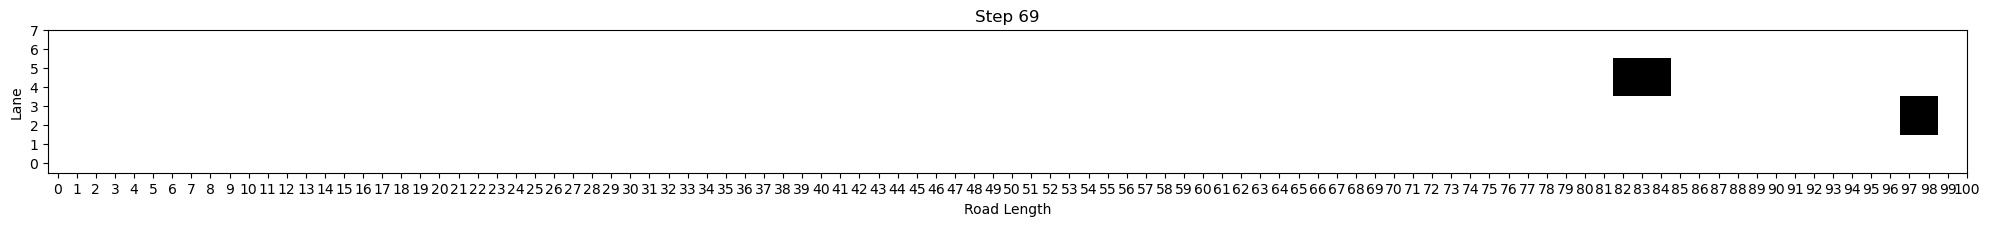

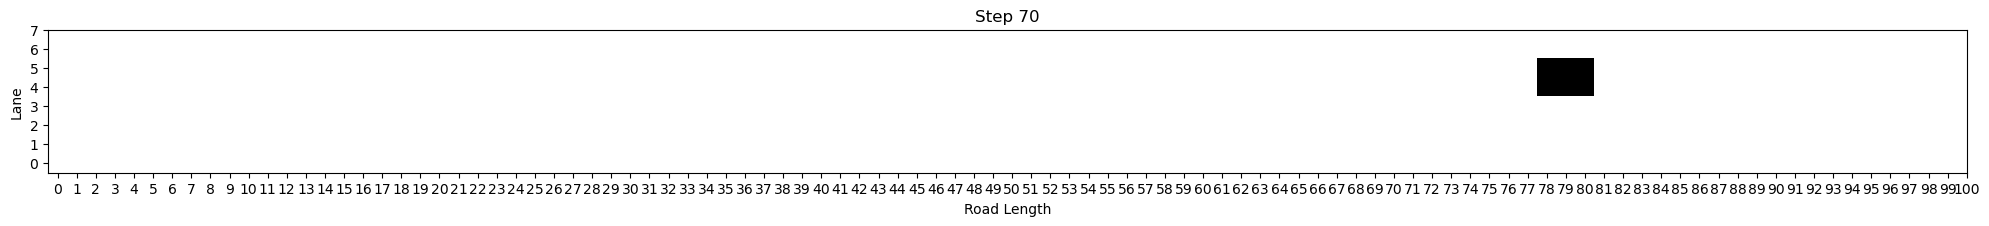

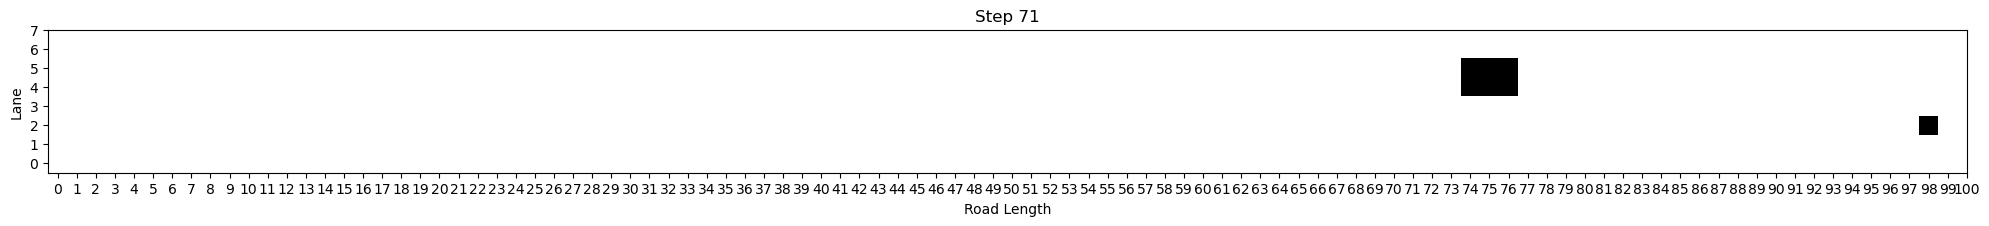

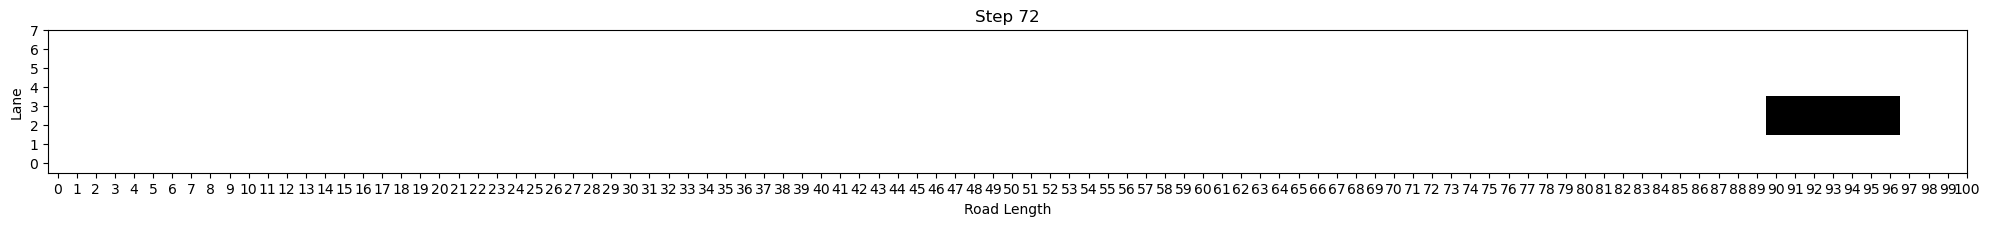

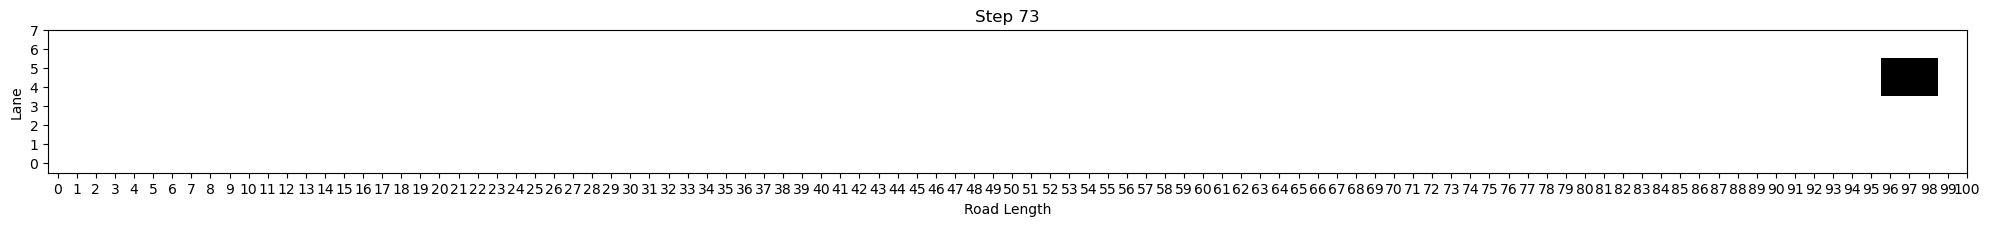

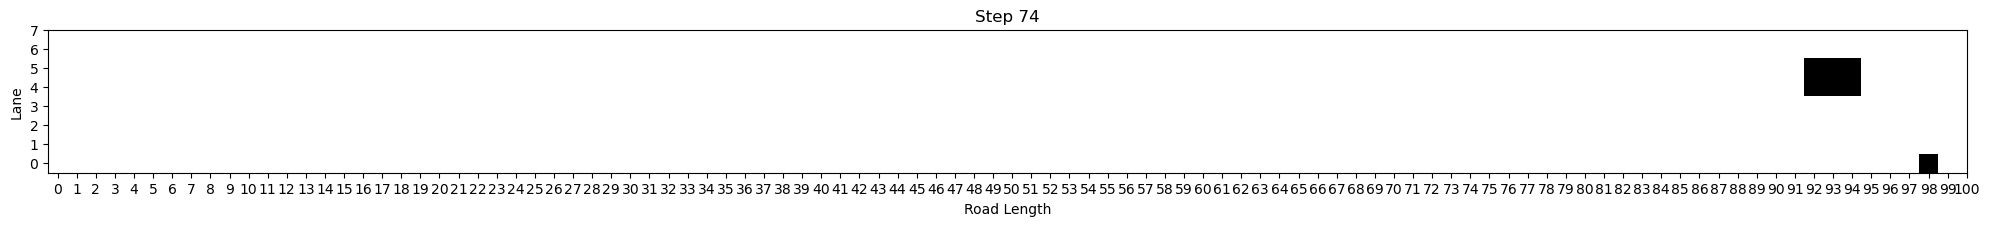

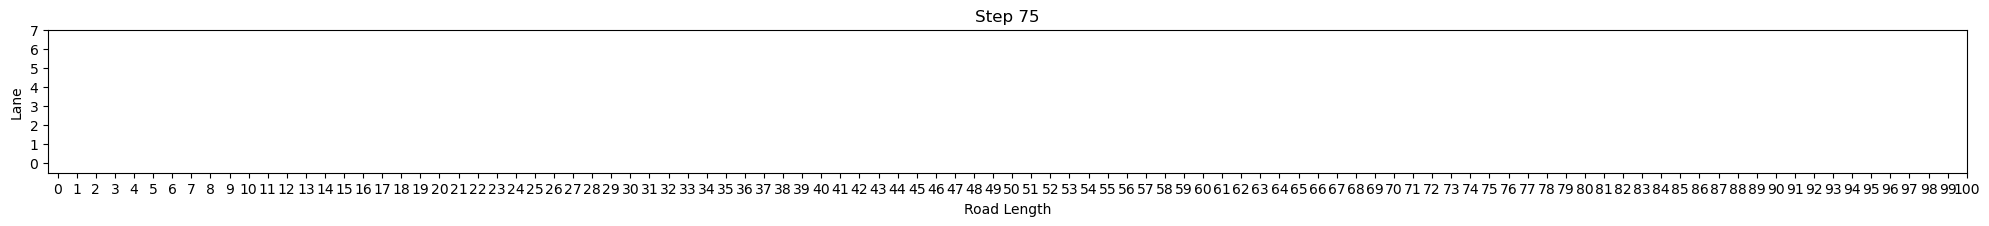

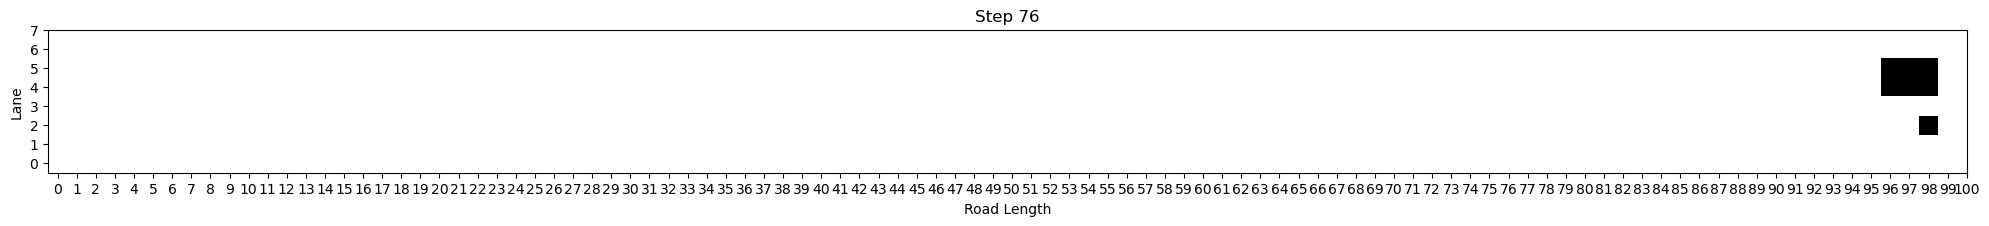

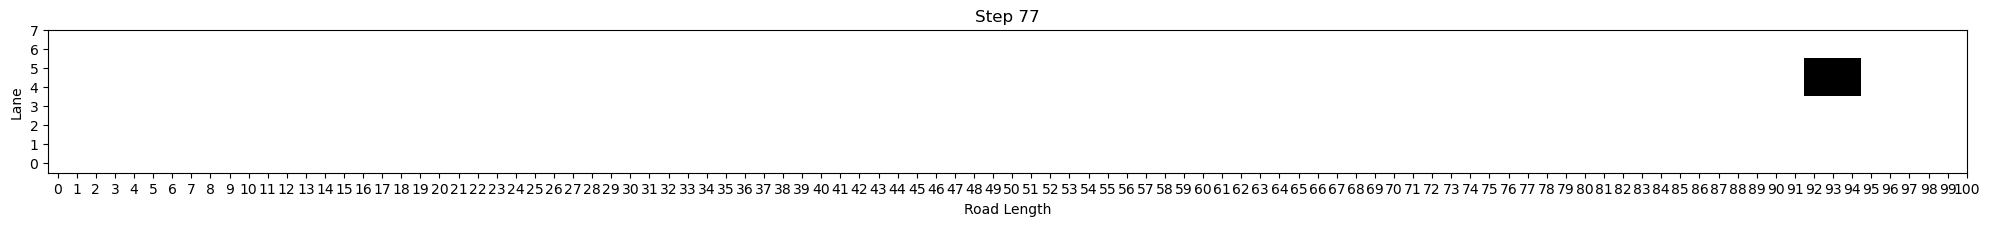

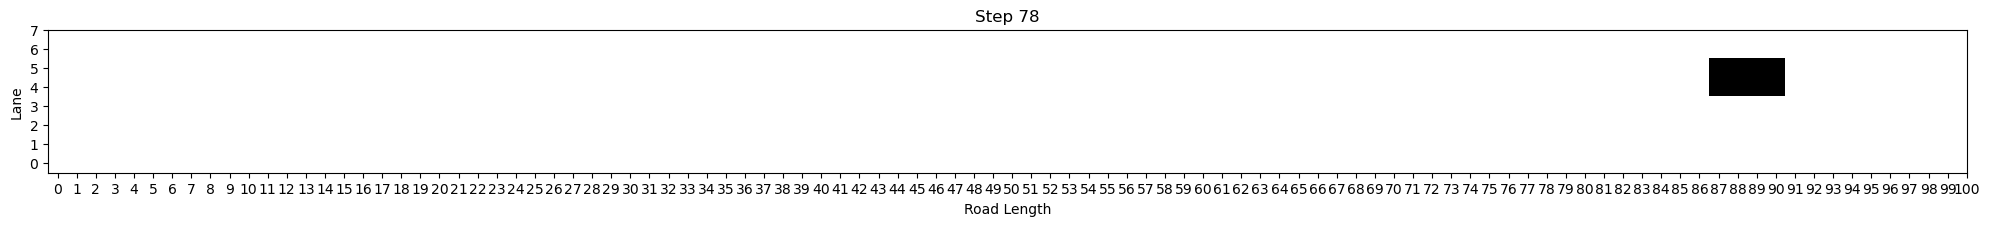

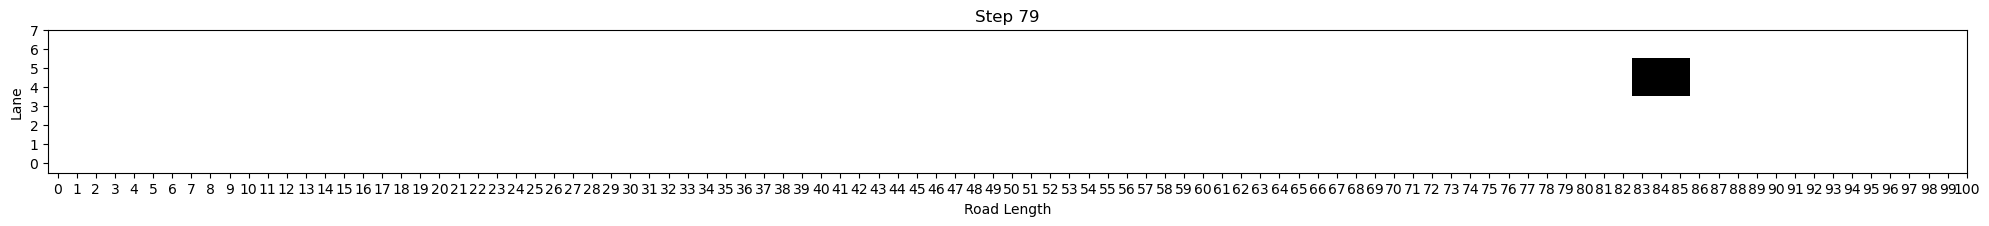

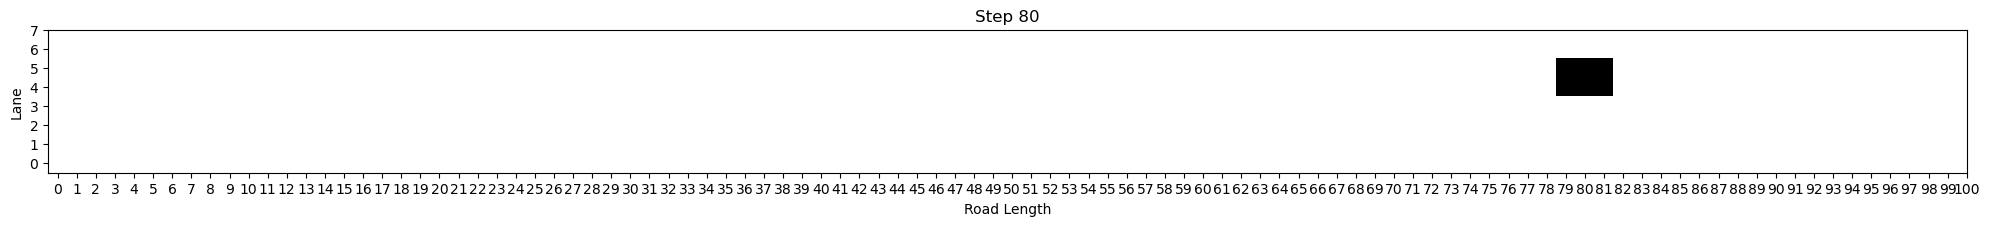

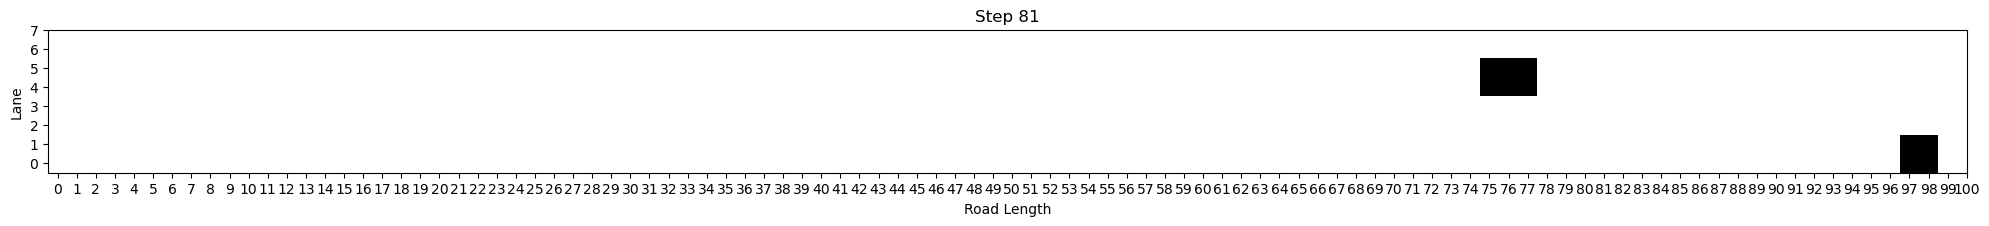

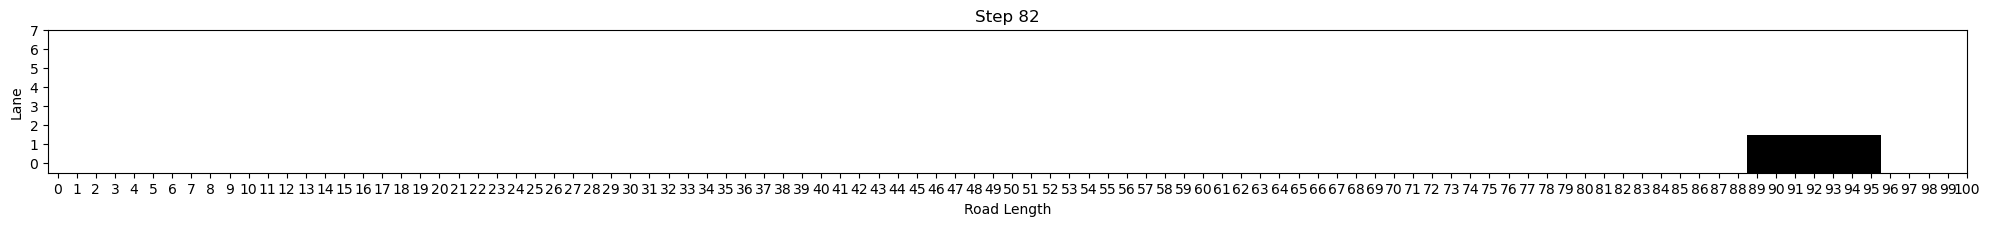

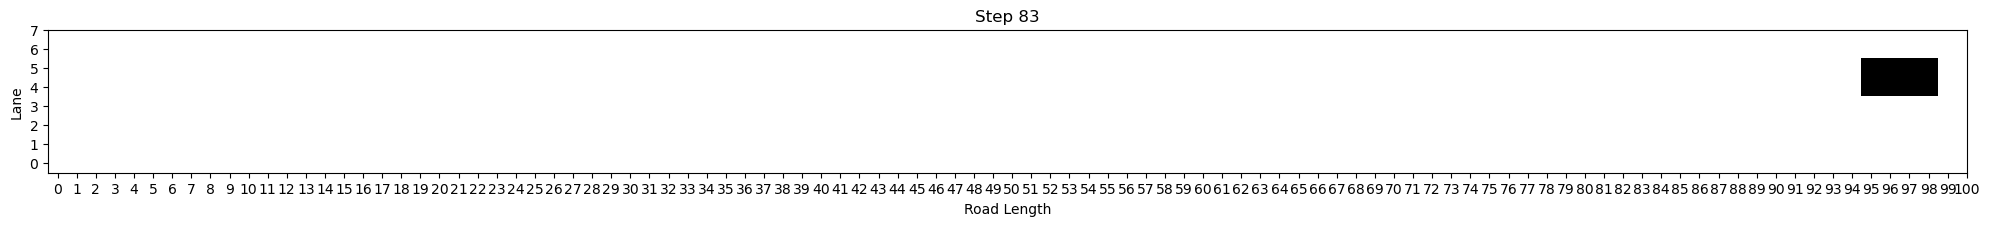

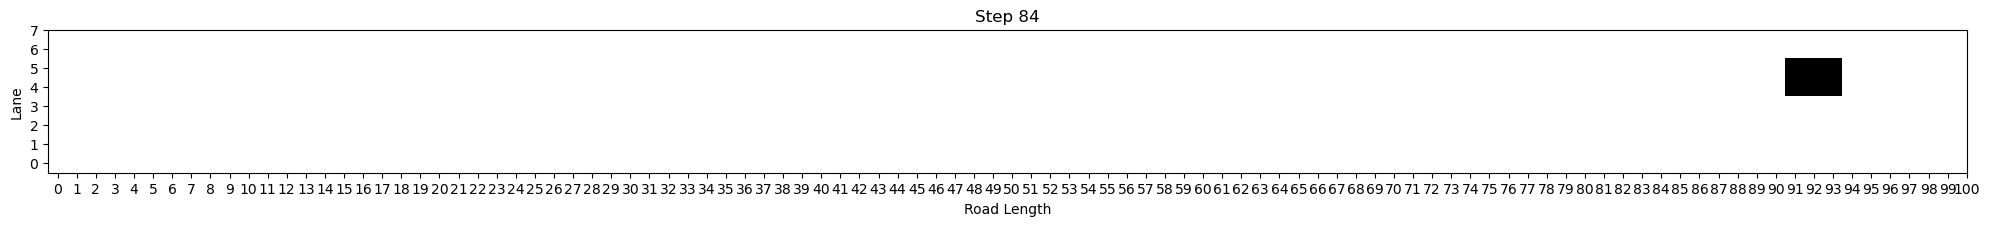

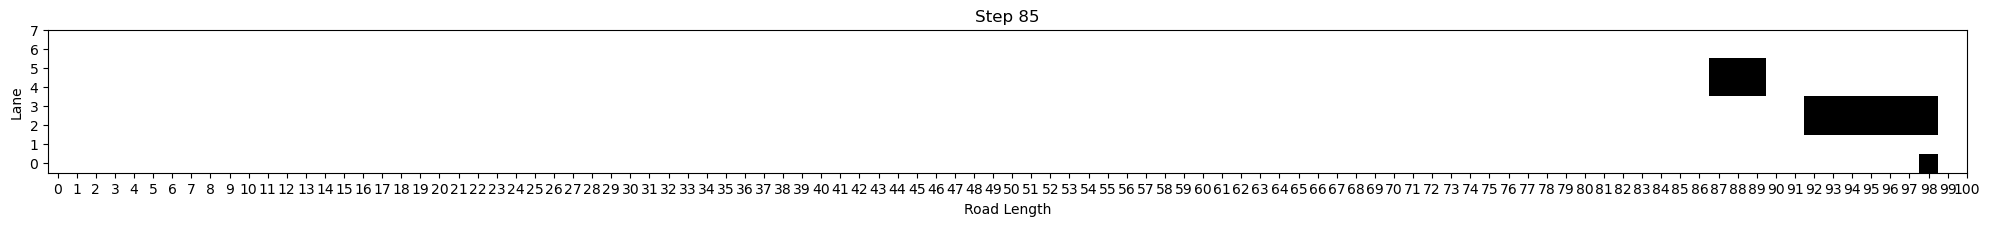

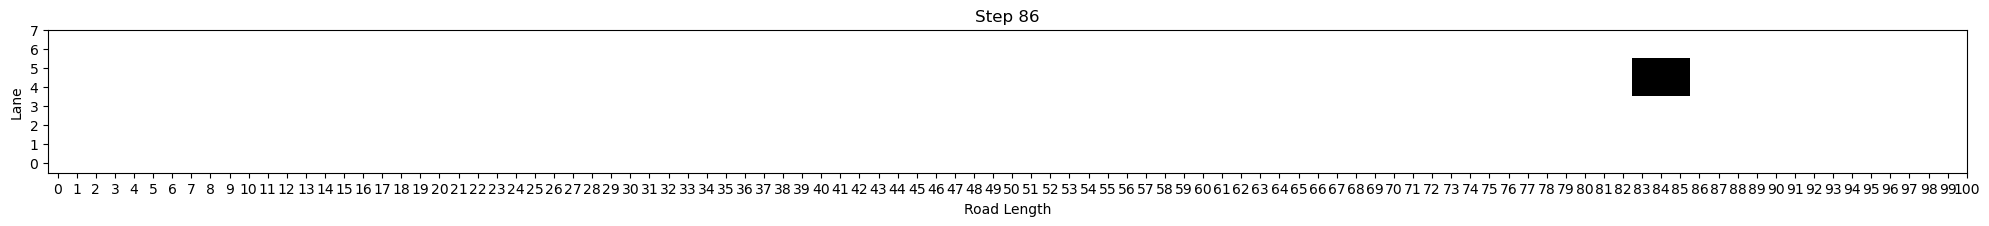

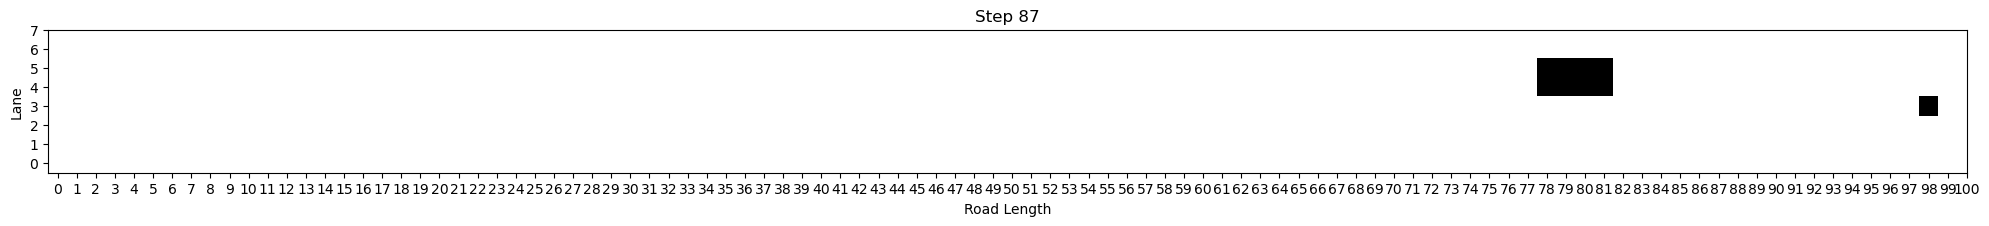

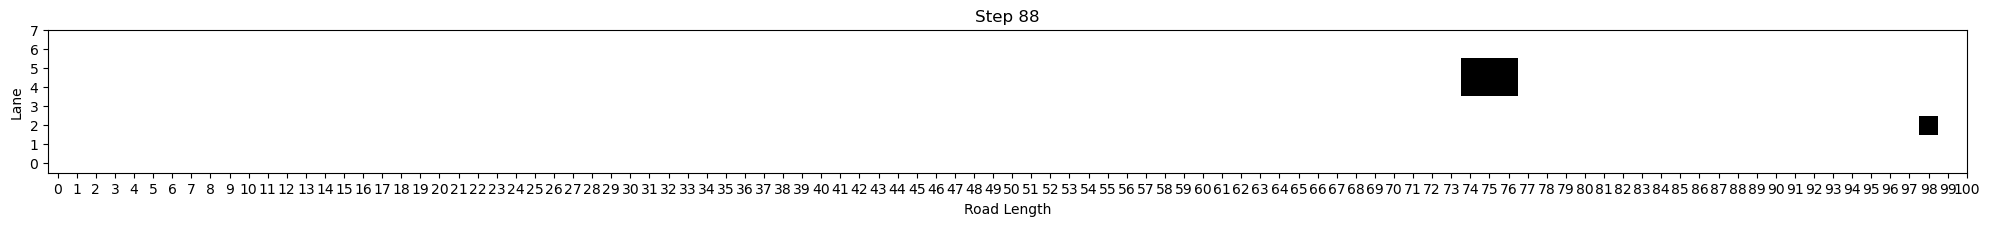

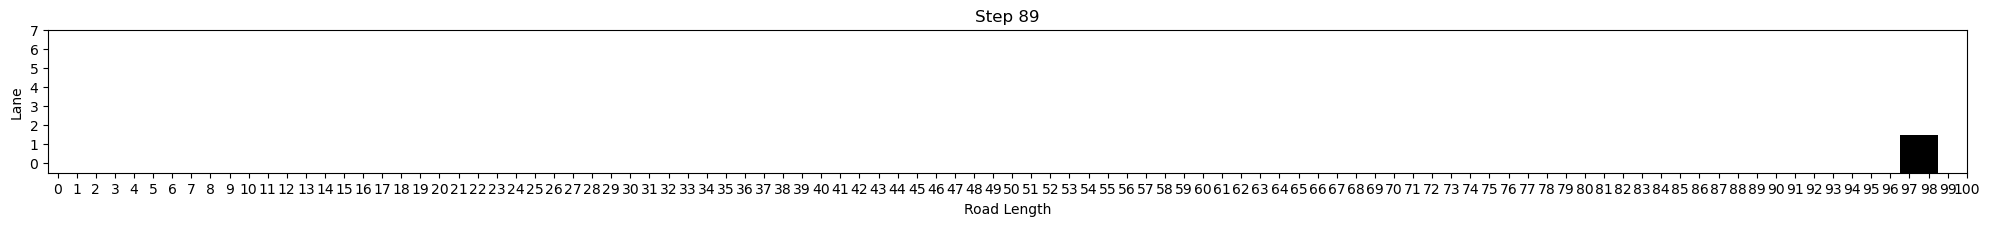

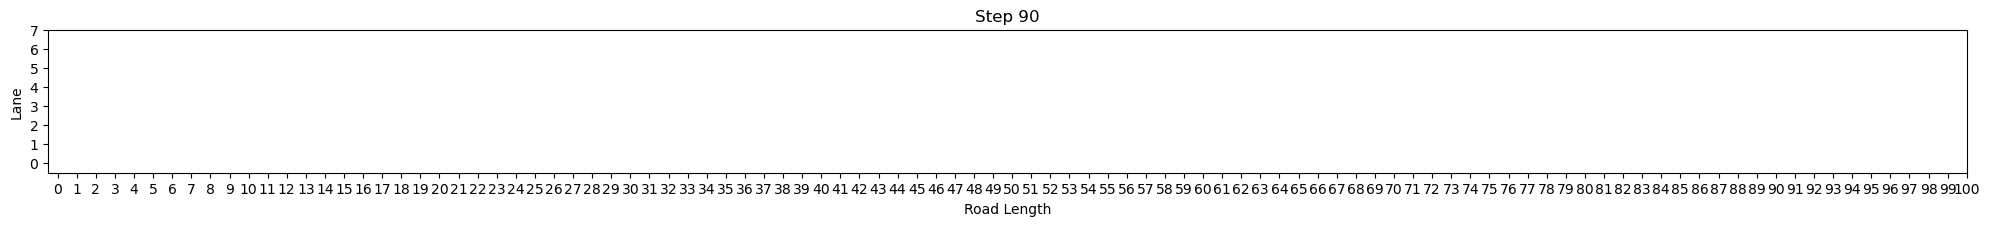

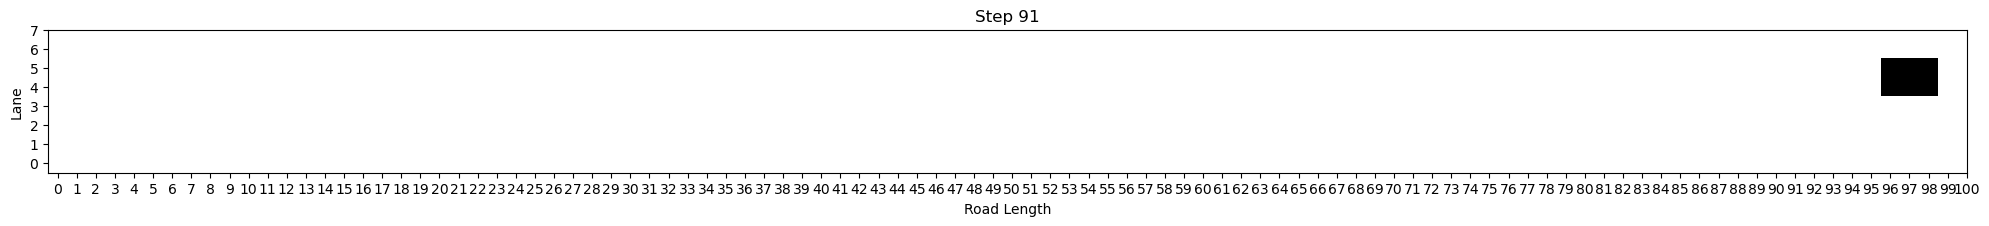

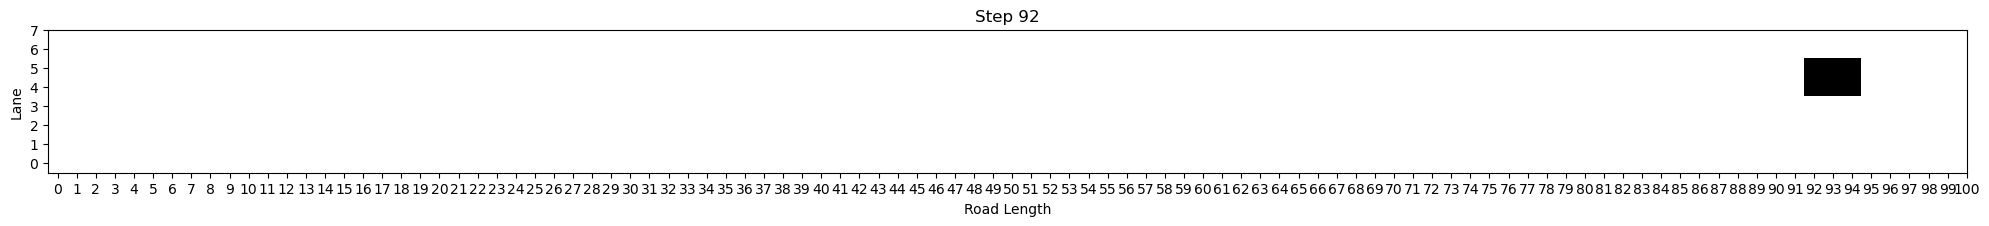

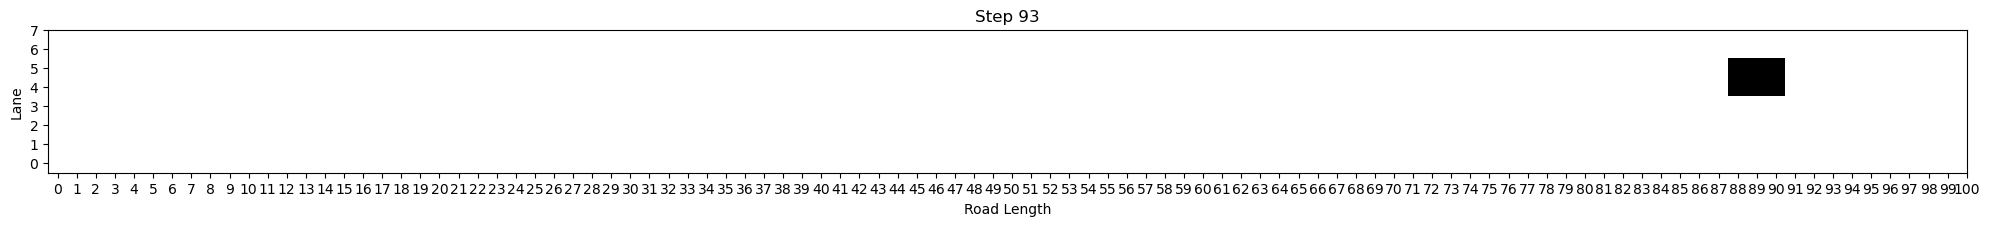

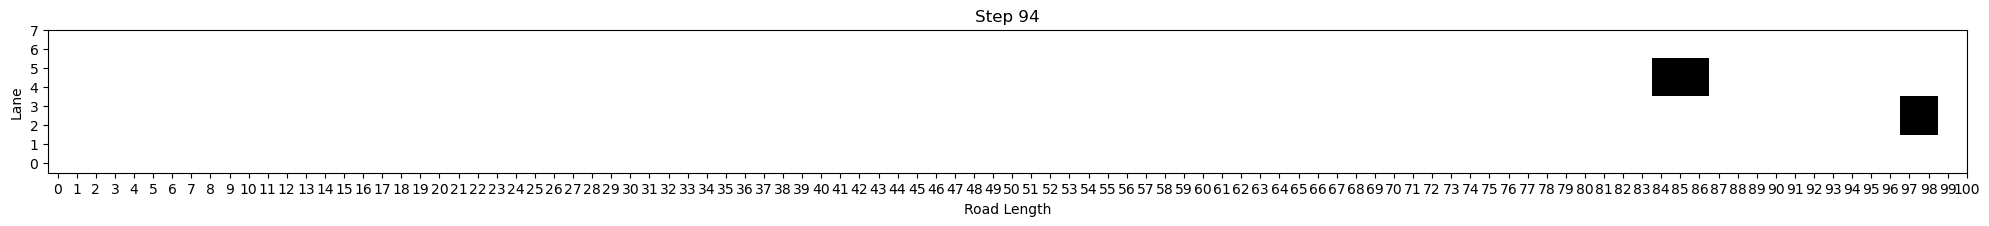

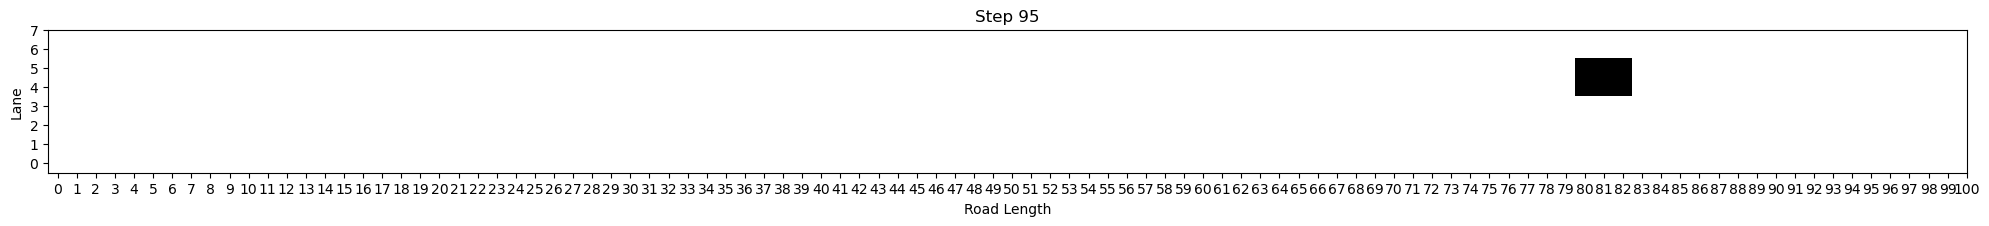

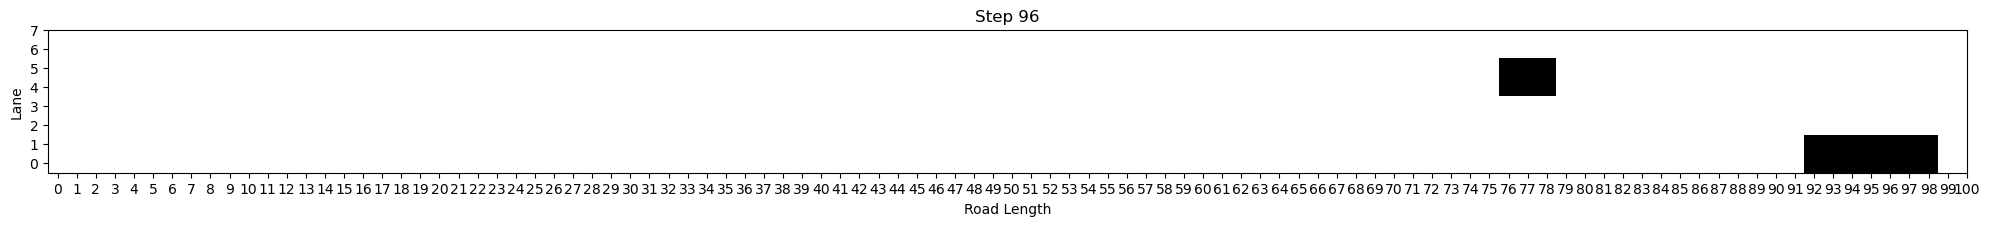

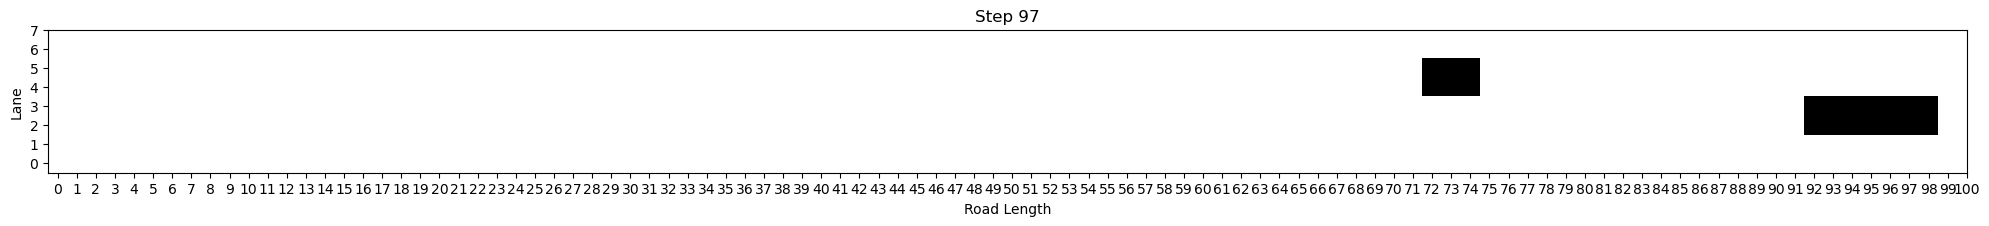

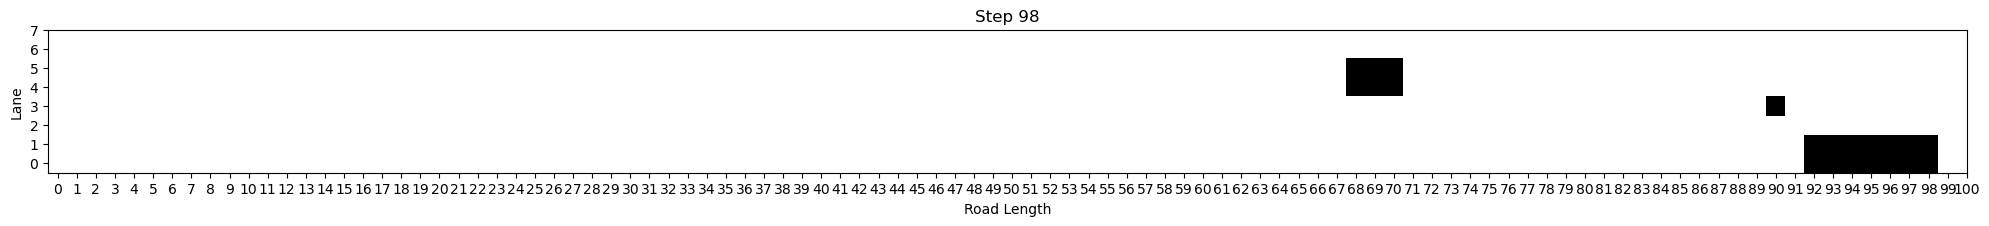

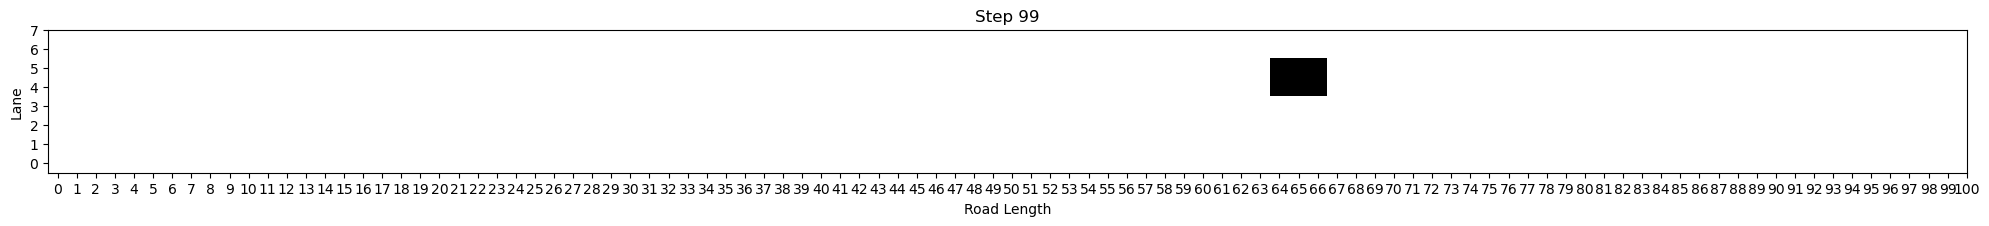

In [27]:
road = Road(road_length=100, road_width=7, speed_limit=5)
simulator = IntraRoadSimulator(road)

for step in range(100):
    simulator.simulation_step()
    if step % 1 == 0:
        simulator.visualize(step)